# Evaluation Pipeline for Summary's Consistency

## Import Libraries

In [ ]:
from collections import Counter

import scipy.stats as stats
from scipy.stats import ttest_ind

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')

from sentence_transformers import SentenceTransformer
import evaluate

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

from utils import *
from models import *
from global_variables import *

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [ ]:
df = pd.read_csv('data/df.csv')

## Exploratory Data Analysis

### Distribution of topic classifications

We plot the distribution of the topic classifications to understand the distribution of the conversations in the dataset.

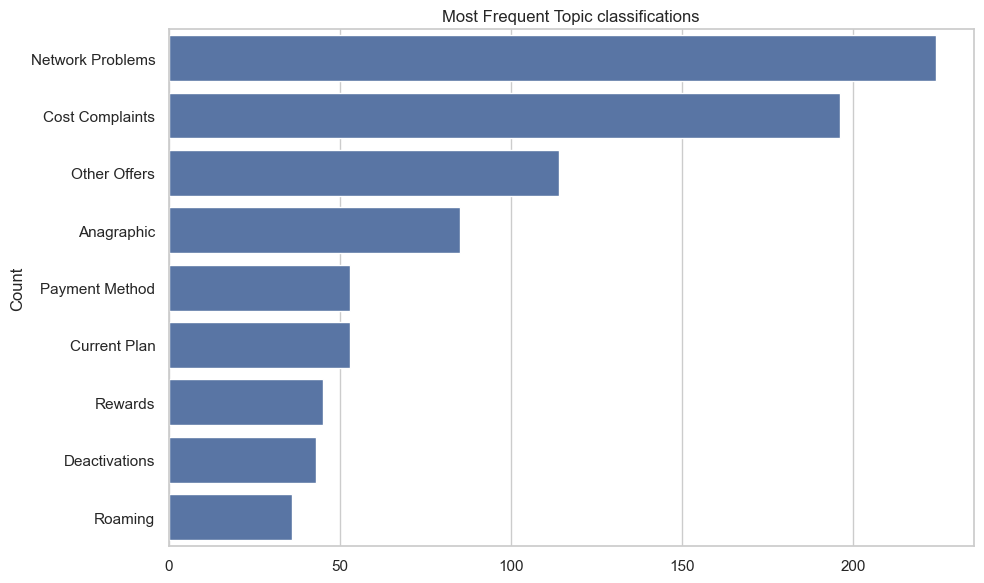

In [6]:
topics = Counter(df['topic']).most_common(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=[l for l,v in topics], x=[v for l,v in topics], orient='h', color='b')
plt.ylabel('Count')
plt.title(f'Most Frequent Topic classifications')
plt.tight_layout()
plt.show()

As we can see, the dataset is unbalanced, with the majority of the conversations being classified as `Network Problems`, in which the customers complain about technical problems with the network.
The second most common classification is `Cost Complaints`, in which the customers ask for explanations about the costs or contest unexpected costs.

### Distributions of lengths

We plot the distributions of the lengths of the conversations and the summaries to understand the lengths of the conversations and summaries in the dataset.

In [ ]:
df[f'n_words_{SUMM1}'] = df[f'{SUMM1}'].apply(lambda x: len(x.split(' ')))
df[f'n_words_{SUMM2}'] = df[f'{SUMM2}'].apply(lambda x: len(x.split(' ')))
df[f'n_words_{SUMM3}'] = df[f'{SUMM3}'].apply(lambda x: len(x.split(' ')))

df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,n_words_conv,n_words_prod,n_words_palm,n_words_gemini
count,1000.00,1000.00,1000.00,1000.00
mean,611.20,106.25,129.13,151.60
std,411.45,42.64,73.64,74.69
min,167.00,17.00,12.00,30.00
25%,322.50,76.00,88.00,104.75
50%,496.00,101.00,118.00,140.00
75%,780.25,127.00,158.00,181.00
max,3125.00,314.00,1744.00,973.00


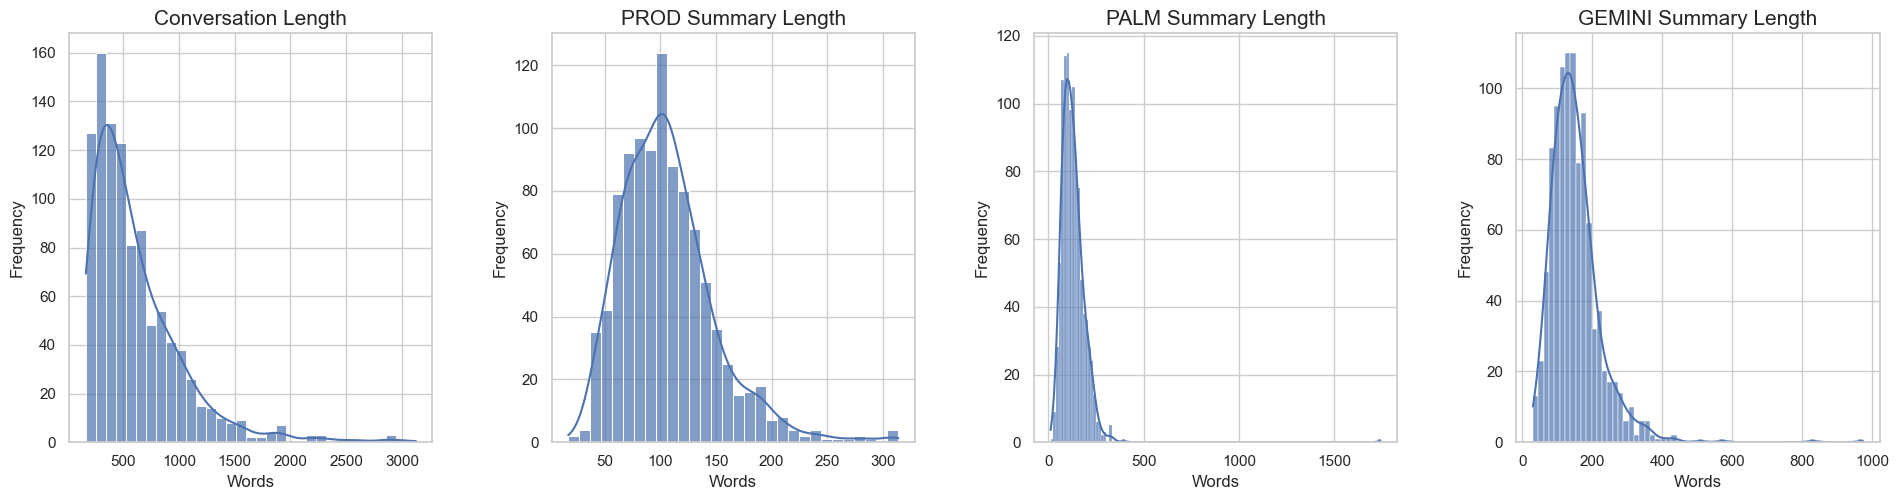

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))

sns.histplot(data=df, x=f'n_words_conv', alpha=0.7, label='CONV', ax=ax[0], kde=True)
sns.histplot(data=df, x=f'n_words_{SUMM1}', alpha=0.7, label=SUMM1.upper(), ax=ax[1], kde=True)
sns.histplot(data=df, x=f'n_words_{SUMM2}', alpha=0.7, label=SUMM2.upper(), ax=ax[2], kde=True)
sns.histplot(data=df, x=f'n_words_{SUMM3}', alpha=0.7, label=SUMM3.upper(), ax=ax[3], kde=True)

ax[0].set_title('Conversation Length', fontsize=15)
ax[0].set_xlabel('Words')
ax[0].set_ylabel('Frequency')

ax[1].set_title(f'{SUMM1.upper()} Summary Length', fontsize=15)
ax[1].set_xlabel(f'Words')
ax[1].set_ylabel('Frequency')

ax[2].set_title(f'{SUMM2.upper()} Summary Length', fontsize=15)
ax[2].set_xlabel(f'Words')
ax[2].set_ylabel('Frequency')

ax[3].set_title(f'{SUMM3.upper()} Summary Length', fontsize=15)
ax[3].set_xlabel(f'Words')
ax[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

As we can see, the length of the summaries is quite similar across the three summarization models. However Gemini tends to generate slightly longer summaries than the other two models. The standard deviations of the optimized summaries are quite similar, while the standard deviation of the summaries in production is slightly lower (potentialli hinting a lower level of informativeness).

The highest value of the lengths of the conversations is around 1700 words, generated by PaLM. However, Gemini generates more summaries with higher lengths than the other two models, as its graph has a longer tail. 

### Correlations of lenghts

Given the distributions of the lengths of the texts, we want to inspect the shortest and longest texts in the dataset and see whether they are correlated.

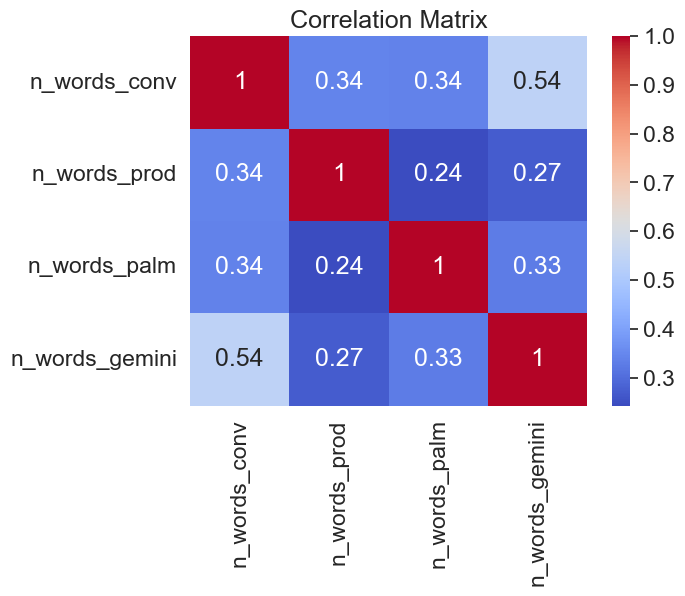

In [ ]:
sns.heatmap(df[[f'n_words_conv', f'n_words_{SUMM1}', f'n_words_{SUMM2}', f'n_words_{SUMM3}']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Shortest texts

From the correlation matrix we can see that the length of the conversation is quite correlated with the length of the summaries, and this result is in line with the espectations.

More in details, the length of the conversation is more correlated with the length of the summary generated by Gemini, maybe hinting a more informative summary. The summaries in production and generated by PaLM are equally correlated with the length of the conversation.

Another result in line with the expectations is that the length of the summaries are correlated with each other, meaning that they share a good baseline of information.

In [ ]:
print(
    f"Min {SUMM1.upper()} length: {df[f'n_words_{SUMM1}'].min()}",
    f"Words of conversation {df[df[f'n_words_{SUMM1}']==df[f'n_words_{SUMM1}'].min()]['n_words_conv'].values[0]}",
    df[df[f'n_words_{SUMM1}']==df[f'n_words_{SUMM1}'].min()].iloc[0][f'{SUMM1}'],
    df[df[f'n_words_{SUMM1}']==df[f'n_words_{SUMM1}'].min()].index,
    sep='\n'
)

Min PROD length: 17
Words of conversation 841
The customer is trying to cancel their Vodafone business contract. The operator is trying to help them.
Int64Index([572], dtype='int64')


In [ ]:
print(
    f"Min {SUMM2.upper()} length: {df[f'n_words_{SUMM2}'].min()}",
    f"Words of conversation {df[df[f'n_words_{SUMM2}']==df[f'n_words_{SUMM2}'].min()]['n_words_conv'].values[0]}",
    df[df[f'n_words_{SUMM2}']==df[f'n_words_{SUMM2}'].min()].iloc[0][f'{SUMM2}'],
    df[df[f'n_words_{SUMM2}']==df[f'n_words_{SUMM2}'].min()].index,
    sep='\n'
)

Min PALM length: 12
Words of conversation 324
The customer wants to add an Internet subscription to their landline phone.
Int64Index([489], dtype='int64')


In [ ]:
print(
    f"Min {SUMM3.upper()} length: {df[f'n_words_{SUMM3}'].min()}",
    f"Words of conversation {df[df[f'n_words_{SUMM3}']==df[f'n_words_{SUMM3}'].min()]['n_words_conv'].values[0]}",
    df[df[f'n_words_{SUMM3}']==df[f'n_words_{SUMM3}'].min()].iloc[0][f'{SUMM3}'],
    df[df[f'n_words_{SUMM3}']==df[f'n_words_{SUMM3}'].min()].index,
    sep='\n'
)

Min GEMINI length: 30
Words of conversation 274
"The customer called Vodafone Customer Service to withdraw from their Sim dati contract. The operator confirms that the withdrawal will be effective immediately and the sim will be deactivated. "
Int64Index([169], dtype='int64')


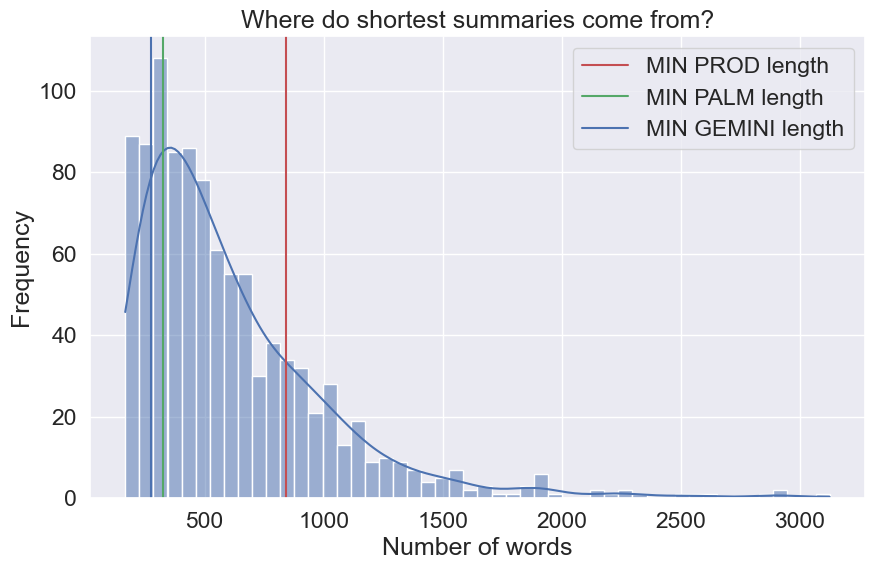

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='n_words_conv', bins=50, kde=True)

plt.axvline(df[df[f'n_words_{SUMM1}']==df[f'n_words_{SUMM1}'].min()]['n_words_conv'].values[0], color='r', label=f'MIN {SUMM1.upper()} length')
plt.axvline(df[df[f'n_words_{SUMM2}']==df[f'n_words_{SUMM2}'].min()]['n_words_conv'].values[0], color='g', label=f'MIN {SUMM2.upper()} length')
plt.axvline(df[df[f'n_words_{SUMM3}']==df[f'n_words_{SUMM3}'].min()]['n_words_conv'].values[0], color='b', label=f'MIN {SUMM3.upper()} length')

plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Where do shortest summaries come from?')
plt.legend()
plt.show()


By plotting the distributions of the conversation lengths and highlighting what is the conversation length of the shortest summaries, we can see that the shortest summary generated by Gemini is associated to a shorter conversation than the shortest PROD and PALM summary.

### Longest texts

In [ ]:
print(
    f"Max {SUMM1.upper()} length: {df[f'n_words_{SUMM1}'].max()}",
    f"Words of conversation {df[df[f'n_words_{SUMM1}']==df[f'n_words_{SUMM1}'].max()]['n_words_conv'].values[0]}",
    df[df[f'n_words_{SUMM1}']==df[f'n_words_{SUMM1}'].max()].iloc[0][f'{SUMM1}'],
    df[df[f'n_words_{SUMM1}']==df[f'n_words_{SUMM1}'].max()].index,
    sep='\n'
)

Max PROD length: 314
Words of conversation 1697
The customer is having problems with their Vodafone Wi-Fi connection. The operator asks the customer to check the lights on the Vodafone station and the customer confirms that they are all on. The operator then asks the customer to try restarting the Vodafone station and the customer agrees. The operator then checks the connection and confirms that the line is working fine. The customer then tells the operator that they have an extender and that they have tried unplugging it, but the problem persists. The operator asks the customer to try restarting the Vodafone station again and the customer agrees. The operator then checks the connection again and confirms that the line is still working fine. The customer then tells the operator that they are still having problems with the connection. The operator asks the customer to check the Wi-Fi channels and the customer confirms that there are a lot of other Vodafone stations and non-Vodafone stat

In [ ]:
print(
    f"Max {SUMM2.upper()} length: {df[f'n_words_{SUMM2}'].max()}",
    f"Words of conversation {df[df[f'n_words_{SUMM2}']==df[f'n_words_{SUMM2}'].max()]['n_words_conv'].values[0]}",
    df[df[f'n_words_{SUMM2}']==df[f'n_words_{SUMM2}'].max()].iloc[0][f'{SUMM2}'],
    df[df[f'n_words_{SUMM2}']==df[f'n_words_{SUMM2}'].max()].index,
    sep='\n'
)

Max PALM length: 1744
Words of conversation 893
The customer complains about not having received the last paper bill and asks about the next bill. The operator informs the customer that the last bill was sent and that the next one will be sent via email after validating the email address. The customer asks about the cost of the next bill and the operator provides the information. The customer asks about the data bundle included in their mobile phone plan and the operator provides the information. The customer asks about the cost of the landline phone plan and the operator provides the information. The customer asks about the cost of the mobile phone plan and the operator provides the information. The customer asks about the cost of the landline phone plan and the operator provides the information. The customer asks about the cost of the mobile phone plan and the operator provides the information. The customer asks about the cost of the landline phone plan and the operator provides the 

We can clearly see that this summary is an example of failure in the summarization process, as after some tokens the summary is a repetition of the sentence:

```"The customer asks about the cost of the landline phone plan and the operator provides the information. The customer asks about the cost of the mobile phone plan and the operator provides the information. The customer asks about the cost of the landline phone plan and the operator provides the information. The customer asks about the cost of the mobile phone plan and the operator provides the information."```

This happens until the maximum length of the summary is reached.

In [ ]:
print(
    f"Max {SUMM3.upper()} length: {df[f'n_words_{SUMM3}'].max()}",
    f"Words of conversation {df[df[f'n_words_{SUMM3}']==df[f'n_words_{SUMM3}'].max()]['n_words_conv'].values[0]}",
    df[df[f'n_words_{SUMM3}']==df[f'n_words_{SUMM3}'].max()].iloc[0][f'{SUMM3}'],
    df[df[f'n_words_{SUMM3}']==df[f'n_words_{SUMM3}'].max()].index,
    sep='\n'
)

Max GEMINI length: 973
Words of conversation 2889
The customer calls the Vodafone customer service reporting they have issues with their fixed line service after having ported their number from Tim to Vodafone. The customer mentions that they have received an email from Vodafone informing them their number is active, however, they are no longer able to use their phone. The customer explains that they have connected their phone to the modem, but it is not working properly, stating that, although they are able to make calls, they are not receiving them: incoming calls seem to be directed to their old Tim line. The operator asks the customer to provide their fixed-line number and, after verifying some information, performs a check on the line. The operator, noticing the line is indeed active, asks the customer to confirm if their phone is connected directly to the modem. The customer confirms they can make outgoing calls, but they reiterate that they do not receive calls on their Vodafone

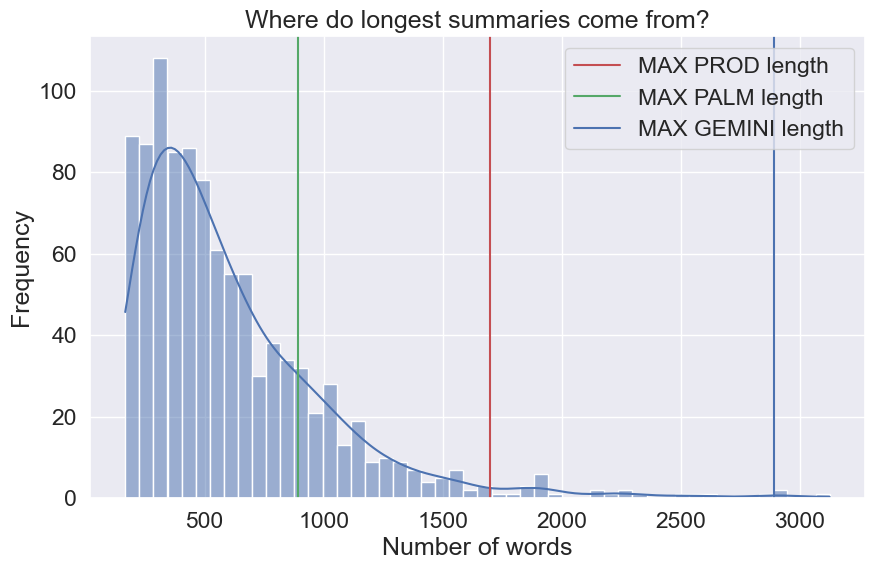

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='n_words_conv', bins=50, kde=True)

plt.axvline(df[df[f'n_words_{SUMM1}']==df[f'n_words_{SUMM1}'].max()]['n_words_conv'].values[0], color='r', label=f'MAX {SUMM1.upper()} length')
plt.axvline(df[df[f'n_words_{SUMM2}']==df[f'n_words_{SUMM2}'].max()]['n_words_conv'].values[0], color='g', label=f'MAX {SUMM2.upper()} length')
plt.axvline(df[df[f'n_words_{SUMM3}']==df[f'n_words_{SUMM3}'].max()]['n_words_conv'].values[0], color='b', label=f'MAX {SUMM3.upper()} length')

plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Where do longest summaries come from?')
plt.legend()
plt.show()


As said for the shortest summaries, Gemini is the model that seems to generate summaries that are more correlated with the length of the conversation, as the longest summary generated by Gemini is associated with the longest conversation.

### Summaries of the shortest conversation

In [ ]:
print(df[df[f'n_words_conv']==df[f'n_words_conv'].min()].iloc[0]['conv'])

### The output is not displayed for confidentiality reasons

In [ ]:
print(f"SUMMARY MADE BY {SUMM1.upper()} FOR THE SHORTEST CONVERSATION:",
    df[df[f'n_words_conv']==df[f'n_words_conv'].min()].iloc[0][f'{SUMM1}'],
    f"Words: {df[f'n_words_{SUMM1}'].min()}",
    sep='\n')

SUMMARY MADE BY PROD FOR THE SHORTEST CONVERSATION:
The customer is having trouble with their Wi-Fi at home. The operator asks for the customer's name and surname to confirm that they are the account holder. The operator then transfers the customer to the technical support department. The technical support operator confirms that the customer is a customer with the same name and surname as the account holder, and that they are having problems with their landline internet connection. The operator asks the customer to wait while they transfer them to the landline support department.
Words: 17


In [ ]:
print(f"SUMMARY MADE BY {SUMM2.upper()} FOR THE SHORTEST CONVERSATION:",
    df[df[f'n_words_conv']==df[f'n_words_conv'].min()].iloc[0][f'{SUMM2}'],
    f"Words: {df[f'n_words_{SUMM2}'].min()}",
    sep='\n')

SUMMARY MADE BY PALM FOR THE SHORTEST CONVERSATION:
The customer complains about the Wi-Fi connection at home, which does not work in the living room and in the kitchen, and the phone is disconnected from it. The operator tries to transfer the call to the technical department but, after consulting a colleague, it turns out that the customer has called the mobile department instead of the landline department. The call is then transferred to the correct department.
Words: 12


In [ ]:
print(f"SUMMARY MADE BY {SUMM3.upper()} FOR THE SHORTEST CONVERSATION:",
    df[df[f'n_words_conv']==df[f'n_words_conv'].min()].iloc[0][f'{SUMM3}'],
    f"Words: {df[f'n_words_{SUMM3}'].min()}",
    sep='\n')

SUMMARY MADE BY GEMINI FOR THE SHORTEST CONVERSATION:
The customer reports that their home Wi-Fi is not working properly. They explain that the Wi-Fi works in one room but not in other areas of the house. The operator asks for the account holder's name. After a brief exchange to confirm the customer's information, the operator places the customer on hold to transfer them to the technical department. Once connected with the technical department, the operator briefs their colleague on the customer's issue, stating that the customer is experiencing problems with their fixed line and internet service.  The call ends with the transfer.
Words: 30


### Summaries of the longest conversation

In [ ]:
print(df[df[f'n_words_conv']==df[f'n_words_conv'].max()].iloc[0]['conv'])

### The output is not displayed for confidentiality reasons

In [ ]:
print(f"SUMMARY MADE BY {SUMM1.upper()} FOR THE LONGEST CONVERSATION:",
    df[df[f'n_words_conv']==df[f'n_words_conv'].max()].iloc[0][f'{SUMM1}'],
    f"Words: {df[f'n_words_{SUMM1}'].max()}",
    sep='\n')

SUMMARY MADE BY PROD FOR THE LONGEST CONVERSATION:
The customer is calling to inquire about a change of tariff for their business landline and mobile phone. The operator informs them that they will be able to save money by switching to the new fibre optic tariff, and that they will also be able to add a second mobile phone line to their account. The customer is happy with this and agrees to the change. The operator then sends the customer a link to a web page where they can confirm the change. The customer also asks about the possibility of adding a second number to their existing Vodafone mobile phone contract. The operator informs them that they can do this by going into a store and requesting a conversion of their personal number to a business number.
Words: 314


In [ ]:
print(f"SUMMARY MADE BY {SUMM2.upper()} FOR THE LONGEST CONVERSATION:",
    df[df[f'n_words_conv']==df[f'n_words_conv'].max()].iloc[0][f'{SUMM2}'],
    f"Words: {df[f'n_words_{SUMM2}'].max()}",
    sep='\n')

SUMMARY MADE BY PALM FOR THE LONGEST CONVERSATION:
The customer, who has a business contract with Vodafone, calls the Customer Service to inquire about the activation of the fiber optic service at the business location. The operator checks the customer's address and confirms that the fiber optic service is available in the area. The customer asks for confirmation about the possibility of having the same costs as the current contract, and the operator informs them that there will be a one-time cost of 5 euros for the change of the tariff and the migration to fiber. The operator also proposes a new mobile plan with unlimited calls, SMS, and 5 GB of data in several foreign countries, at a reduced price compared to the current one. The customer expresses concerns about a second phone line connected to the business landline, which would be deactivated with the new offer, and the operator explains that the customer will lose the second landline number but will still be able to receive calls 

In [ ]:
print(f"SUMMARY MADE BY {SUMM3.upper()} FOR THE LONGEST CONVERSATION:",
    df[df[f'n_words_conv']==df[f'n_words_conv'].max()].iloc[0][f'{SUMM3}'],
    f"Words: {df[f'n_words_{SUMM3}'].max()}",
    sep='\n')

SUMMARY MADE BY GEMINI FOR THE LONGEST CONVERSATION:
"The customer called Vodafone Customer Service to enquire about the possibility of activating fiber optic service at their business location. The customer was unsure if fiber optic service was available in their area and what the costs would be. The operator checked the customer's address and confirmed that fiber optic service was available. The operator then went over the different fiber optic plans available and the associated costs. The customer was satisfied with the information provided and agreed to switch to a fiber optic plan.   The customer also enquired about their mobile phone plan and whether there were any better offers available. The operator reviewed the customer's current plan and confirmed that there was a cheaper plan available with more data included. The customer agreed to switch to the new mobile phone plan.  Finally, the customer enquired about the possibility of adding a second phone number to their account. Th

Even though conversations are quite long, the summaries are similar in length.

### Most common n-grams

After having inspected the lengths of the conversations and summaries, we want to understand the most common n-grams in the dataset with respect to each model.

We start by initializing the `PorterStemmer`, the `WordNetLemmatizer`, the `stop_words` and the `RegexpTokenizer` that will be used to preprocess the text.

Then we define a function called `most_common_ngrams` that will be used to extract the most common n-grams from the texts.
The function takes as input the column of the DataFrame containing the texts, the DataFrame itself and the number of n-grams to extract, set to 2 by default.

In [ ]:
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

def most_common_ngrams(col, df=df, n=2):
    
    words = df[col].apply(lambda x: tokenizer.tokenize(x))
    words = [lemmatizer.lemmatize(w.lower()) for word in words for w in word]
    words = [w for w in words if not w in stop_words]

    def _ngram_generator(words, n):
        for i in range(len(words) - n + 1):
            yield tuple(words[i:i + n])

    ngrams = _ngram_generator(words, n)
    counts = Counter(ngrams).most_common(20)
    
    return counts

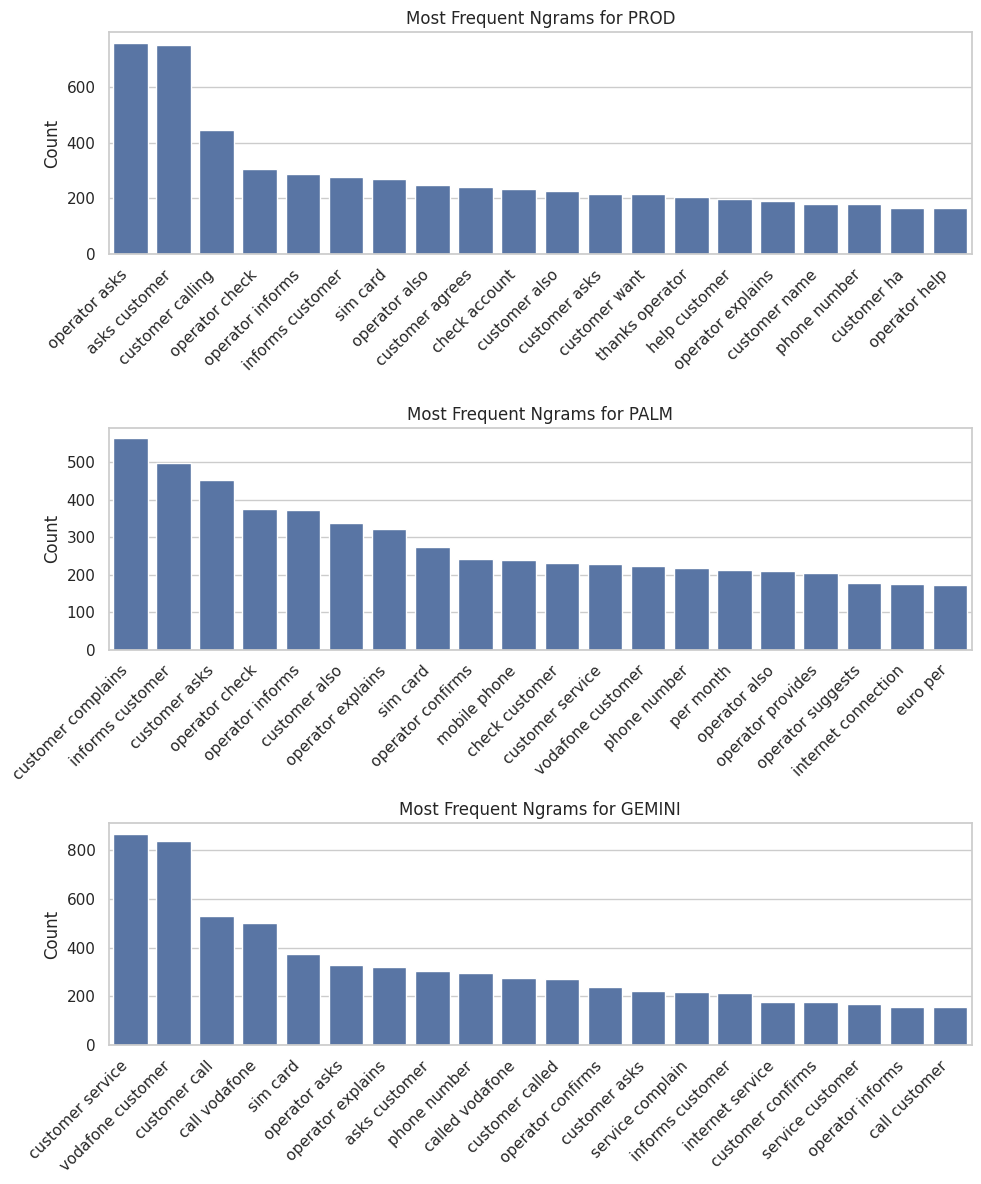

In [ ]:
ngrams_summ1 = most_common_ngrams(SUMM1, n=2)
ngrams_summ2 = most_common_ngrams(SUMM2, n=2)
ngrams_summ3 = most_common_ngrams(SUMM3, n=2)

labels_summ1 = [ngram for ngram, count in ngrams_summ1]
labels_summ1 = [' '.join(t) for t in labels_summ1]
values_summ1 = [count for ngram, count in ngrams_summ1]

labels_summ2 = [ngram for ngram, count in ngrams_summ2]
labels_summ2 = [' '.join(t) for t in labels_summ2]
values_summ2 = [count for ngram, count in ngrams_summ2]

labels_summ3 = [ngram for ngram, count in ngrams_summ3]
labels_summ3 = [' '.join(t) for t in labels_summ3]
values_summ3 = [count for ngram, count in ngrams_summ3]

fig, axes = plt.subplots(3, 1, figsize=(10, 12))
sns.barplot(x=labels_summ1, y=values_summ1, ax=axes[0])
axes[0].set_ylabel('Count')
axes[0].set_title(f'Most Frequent Ngrams for {SUMM1.upper()}')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

sns.barplot(x=labels_summ2, y=values_summ2, ax=axes[1])
axes[1].set_ylabel('Count')
axes[1].set_title(f'Most Frequent Ngrams for {SUMM2.upper()}')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

sns.barplot(x=labels_summ3, y=values_summ3, ax=axes[2])
axes[2].set_ylabel('Count')
axes[2].set_title(f'Most Frequent Ngrams for {SUMM3.upper()}')
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

By looking at the charts we can see that `customer` and `operator` appear in almost all top bigrams. This is of course expected, as the conversations are between a customer and an operator and the sentences in the summaries are quite simple.

No relevant result can be extracted from the plots, so we look at the most common bigrams per call classification.

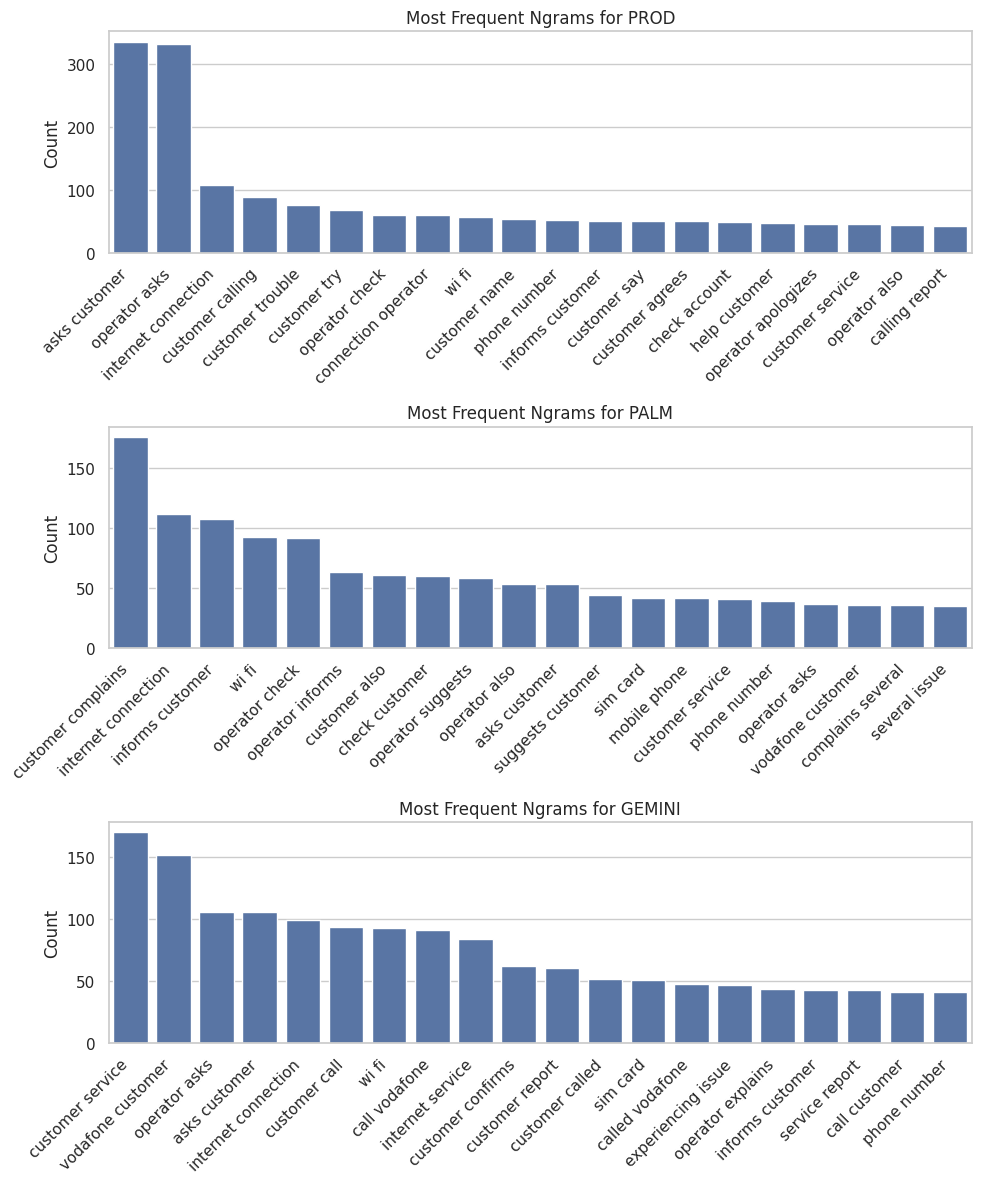

In [ ]:
topic = "Network Problems"

ngrams_summ1 = most_common_ngrams(SUMM1, df[df['topic']==topic], n=2)
ngrams_summ2 = most_common_ngrams(SUMM2, df[df['topic']==topic], n=2)
ngrams_summ3 = most_common_ngrams(SUMM3, df[df['topic']==topic], n=2)

labels_summ1 = [ngram for ngram, count in ngrams_summ1]
labels_summ1 = [' '.join(t) for t in labels_summ1]
values_summ1 = [count for ngram, count in ngrams_summ1]

labels_summ2 = [ngram for ngram, count in ngrams_summ2]
labels_summ2 = [' '.join(t) for t in labels_summ2]
values_summ2 = [count for ngram, count in ngrams_summ2]

labels_summ3 = [ngram for ngram, count in ngrams_summ3]
labels_summ3 = [' '.join(t) for t in labels_summ3]
values_summ3 = [count for ngram, count in ngrams_summ3]

fig, axes = plt.subplots(3, 1, figsize=(10, 12))
sns.barplot(x=labels_summ1, y=values_summ1, ax=axes[0])
axes[0].set_ylabel('Count')
axes[0].set_title(f'Most Frequent Ngrams for {SUMM1.upper()}')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

sns.barplot(x=labels_summ2, y=values_summ2, ax=axes[1])
axes[1].set_ylabel('Count')
axes[1].set_title(f'Most Frequent Ngrams for {SUMM2.upper()}')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

sns.barplot(x=labels_summ3, y=values_summ3, ax=axes[2])
axes[2].set_ylabel('Count')
axes[2].set_title(f'Most Frequent Ngrams for {SUMM3.upper()}')
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Now, by filtering only the conversation classified as `Network Problems`, we can see that the most frequent ngrams are different from the general ones.
In particular, we see bigrams related to the classification, such as `internet connection`, `wi fi`, `internet service`, `sim card`, etc.

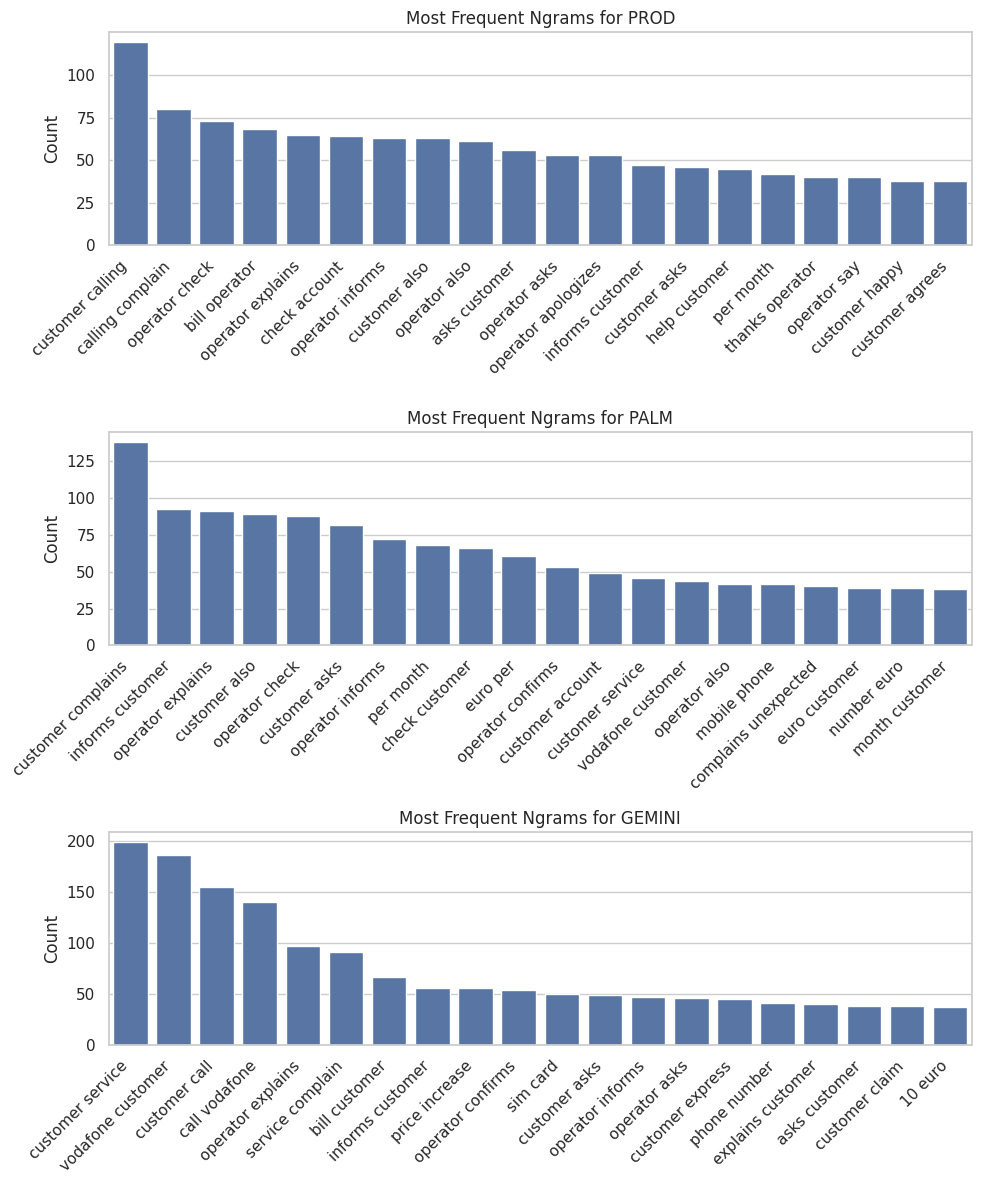

In [ ]:
topic = 'Cost Complaints'

ngrams_summ1 = most_common_ngrams(SUMM1, df[df['topic']==topic], n=2)
ngrams_summ2 = most_common_ngrams(SUMM2, df[df['topic']==topic], n=2)
ngrams_summ3 = most_common_ngrams(SUMM3, df[df['topic']==topic], n=2)

labels_summ1 = [ngram for ngram, count in ngrams_summ1]
labels_summ1 = [' '.join(t) for t in labels_summ1]
values_summ1 = [count for ngram, count in ngrams_summ1]

labels_summ2 = [ngram for ngram, count in ngrams_summ2]
labels_summ2 = [' '.join(t) for t in labels_summ2]
values_summ2 = [count for ngram, count in ngrams_summ2]

labels_summ3 = [ngram for ngram, count in ngrams_summ3]
labels_summ3 = [' '.join(t) for t in labels_summ3]
values_summ3 = [count for ngram, count in ngrams_summ3]

fig, axes = plt.subplots(3, 1, figsize=(10, 12))
sns.barplot(x=labels_summ1, y=values_summ1, ax=axes[0])
axes[0].set_ylabel('Count')
axes[0].set_title(f'Most Frequent Ngrams for {SUMM1.upper()}')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

sns.barplot(x=labels_summ2, y=values_summ2, ax=axes[1])
axes[1].set_ylabel('Count')
axes[1].set_title(f'Most Frequent Ngrams for {SUMM2.upper()}')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

sns.barplot(x=labels_summ3, y=values_summ3, ax=axes[2])
axes[2].set_ylabel('Count')
axes[2].set_title(f'Most Frequent Ngrams for {SUMM3.upper()}')
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Also, by filtering only the conversation classified as `Cost Complaints`, we can see that the most frequent ngrams are even more different from the previous ones.
In particular, we see bigrams related to the classification, such as `price increase`, `per month`, `bill customer`, `service complain`, etc.

However, by looking at the n-grams frequency, the summaries in production appear to be the summaries with the most general n-grams, possibly underlying a lack of informativeness.

## First Evaluation (run by PaLM)

In [ ]:
model = 'palm'

### Comprehensible

In [ ]:
df_palm = palm_call_mt(
    df,
    column_text='conv',
    column_questions='conv',
    column_output=f'{model}_comprehensible',
    prompt=PROMPT_COMPREHENSIBLE,
    model=model_palm,
    model_config=model_config,
    goal='comprehensible'
)

In [ ]:
df_palm[f'{model}_comprehensible_json'] = df_palm[f'{model}_comprehensible'].apply(extract_json)
df_palm = df_palm[df_palm[f"{model}_comprehensible_json"] != "ERROR"]
df_palm[f'{model}_comprehensible_json'] = df_palm[f'{model}_comprehensible_json'].apply(lambda x: x['comprehensible'])
df_palm[f'{model}_comprehensible_json'].value_counts()

palm_comprehensible_json
Yes    934
No      66
Name: count, dtype: int64

### Question Generation

In [ ]:
columns = [
    "conv",
    SUMM1,
    SUMM2,
    SUMM3,
]

for col in columns:
    
    print(f"\nGenerating questions from {col.upper()}")
    
    df_palm = palm_call_mt(
        df_palm,
        column_text = col,
        column_questions = col,
        column_output = f'{model}_output_from_{col}',
        prompt = QUEST_PROMPT,
        model = model_palm,
        model_config = model_config,
        goal = 'generate_questions'
    )
    
    df_palm[f'{model}_quest_from_{col}'] = df_palm[f'{model}_output_from_{col}'].apply(extract_json)
    df_palm = df_palm[df_palm[f'{model}_quest_from_{col}']!="ERROR"]
    df_palm[f'{model}_quest_from_{col}'] = df_palm[f'{model}_quest_from_{col}'].apply(lambda x: x['questions'])

### Answer Generation

In [ ]:
source_and_questions = [
    ("conv", "conv"),
    (SUMM1, "conv"),
    (SUMM2, "conv"),
    (SUMM3, "conv"),
    ("conv", SUMM1),
    (SUMM1, SUMM1),
    ("conv", SUMM2),
    (SUMM2, SUMM2),
    ("conv", SUMM3),
    (SUMM3, SUMM3),
]

for text, source in source_and_questions:
    
    print(f"Generating answers for {text.upper()} from {source.upper()}")
    
    df_palm = palm_call_mt(
        df_palm,
        column_text = text,
        column_questions = f"{model}_quest_from_{source}",
        column_output = f"{model}_answ_{text}_from_{source}",
        threads = THREADS,
        prompt = ANSW_PROMPT,
        model = model_palm,
        model_config = model_config,
        goal = 'generate_answers'
    )
    
    df_palm[f'{model}_answ_{text}_from_{source}'] = df_palm[f'{model}_answ_{text}_from_{source}'].apply(lambda x: extract_json(x))  
    df_palm = df_palm[df_palm[f'{model}_answ_{text}_from_{source}']!="ERROR"]
    df_palm[f'{model}_answ_{text}_from_{source}'] = df_palm[f'{model}_answ_{text}_from_{source}'].apply(lambda x: x['answers'])

### Score Computation
Comparing Summaries in production VS Summaries generated by PaLM using PaLM as evaluator

In [ ]:
V = 1

for S in summaries:
    df_palm[f"{model}_hall_scr_{S}_{V}"] = df_palm.apply(lambda row: compute_hallucination_score(row, model, S, V=V), axis=1)
    df_palm[f"{model}_contr_scr_{S}_{V}"] = df_palm.apply(lambda row: compute_contradiction_score(row, model, S), axis=1)
    df_palm[f"{model}_noninfo_scr_{S}_{V}"] = df_palm.apply(lambda row: compute_noninformativeness_score(row, model, S, V=V), axis=1)

pd.DataFrame({
    'Summary': [SUMM1, SUMM2, SUMM3],
    'Average Hallucination Score': [df_palm[f"{model}_hall_scr_{SUMM1}_{V}"].mean() for S in [SUMM1, SUMM2, SUMM3]],
    'Average Contradiction Score': [df_palm[f"{model}_contr_scr_{S}_{V}"].mean() for S in [SUMM1, SUMM2, SUMM3]],
    'Average Noninformativeness Score': [df_palm[f"{model}_noninfo_scr_{S}_{V}"].mean() for S in [SUMM1, SUMM2, SUMM3]]
})

,Summary,Average Hallucination Score,Average Contradiction Score,Average Noninformativeness Score
0,prod,0.437901,1.244111,1.414347
1,palm,0.359743,1.041756,1.062099
2,gemini,0.328694,1.014989,1.039615


In [ ]:
df_palm[
    [
        f'{model}_hall_scr_{SUMM1}_{V}',
        f'{model}_hall_scr_{SUMM2}_{V}',
        f'{model}_hall_scr_{SUMM3}_{V}',
        f'{model}_contr_scr_{SUMM1}_{V}',
        f'{model}_contr_scr_{SUMM2}_{V}',
        f'{model}_contr_scr_{SUMM3}_{V}',
        f'{model}_noninfo_scr_{SUMM1}_{V}',
        f'{model}_noninfo_scr_{SUMM2}_{V}',
        f'{model}_noninfo_scr_{SUMM3}_{V}'
    ]
].describe()

,palm_hall_scr_prod_1,palm_hall_scr_palm_1,palm_hall_scr_gemini_1,palm_contr_scr_prod_1,palm_contr_scr_palm_1,palm_contr_scr_gemini_1,palm_noninfo_scr_prod_1,palm_noninfo_scr_palm_1,palm_noninfo_scr_gemini_1
count,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000
mean,0.437901,0.359743,0.328694,1.244111,1.041756,1.014989,1.414347,1.062099,1.039615
std,0.743603,0.655692,0.583895,1.162261,1.025595,1.003632,1.042838,0.949078,0.917575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,4.000000,5.000000,4.000000,6.000000,6.000000,6.000000,5.000000,5.000000,5.000000


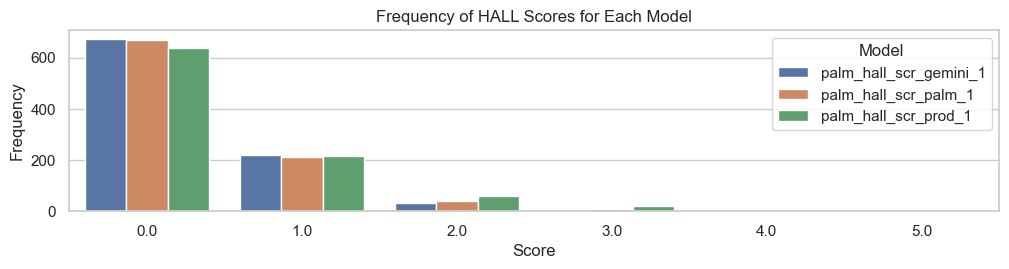

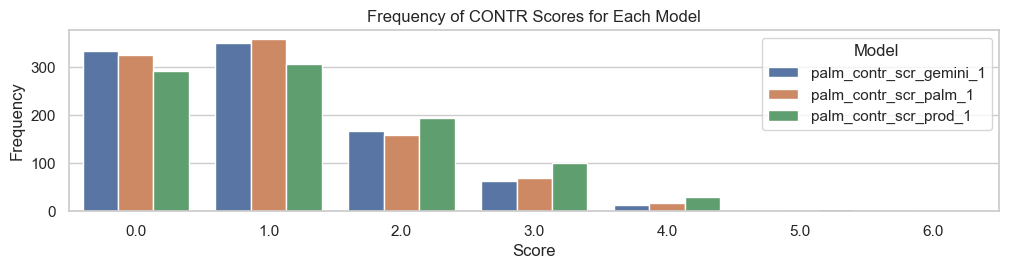

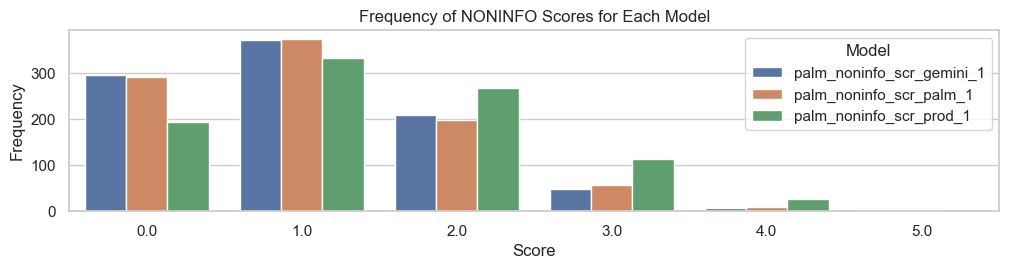

In [ ]:
plot_score_distributions(df=df_palm, model=model)

Using PaLM as evaluator, Gemini results to be the most accurate and consistent model of summarization.
There are complessively very few hallucinations, while the number of contradictions and noninformativeness tends to be one or more for more than two thirds of the times.

In [ ]:
V = 2

for S in summaries:
    df_palm[f"{model}_hall_scr_{S}_{V}"] = df_palm.apply(lambda row: compute_hallucination_score(row, model, S, V=V), axis=1)
    df_palm[f"{model}_contr_scr_{S}_{V}"] = df_palm.apply(lambda row: compute_contradiction_score(row, model, S), axis=1)
    df_palm[f"{model}_noninfo_scr_{S}_{V}"] = df_palm.apply(lambda row: compute_noninformativeness_score(row, model, S, V=V), axis=1)

pd.DataFrame({
    'Summary': [SUMM1, SUMM2, SUMM3],
    'Average Hallucination Score': [df_palm[f"{model}_hall_scr_{SUMM1}_{V}"].mean() for S in [SUMM1, SUMM2, SUMM3]],
    'Average Contradiction Score': [df_palm[f"{model}_contr_scr_{S}_{V}"].mean() for S in [SUMM1, SUMM2, SUMM3]],
    'Average Noninformativeness Score': [df_palm[f"{model}_noninfo_scr_{S}_{V}"].mean() for S in [SUMM1, SUMM2, SUMM3]]
})

,Summary,Average Hallucination Score,Average Contradiction Score,Average Noninformativeness Score
0,prod,0.256959,1.244111,0.972163
1,palm,0.190578,1.041756,0.750535
2,gemini,0.160600,1.014989,0.726981


In [ ]:
df_palm[
    [
        f'{model}_hall_scr_{SUMM1}_{V}',
        f'{model}_hall_scr_{SUMM2}_{V}',
        f'{model}_hall_scr_{SUMM3}_{V}',
        f'{model}_contr_scr_{SUMM1}_{V}',
        f'{model}_contr_scr_{SUMM2}_{V}',
        f'{model}_contr_scr_{SUMM3}_{V}',
        f'{model}_noninfo_scr_{SUMM1}_{V}',
        f'{model}_noninfo_scr_{SUMM2}_{V}',
        f'{model}_noninfo_scr_{SUMM3}_{V}'
    ]
].describe()

,palm_hall_scr_prod_2,palm_hall_scr_palm_2,palm_hall_scr_gemini_2,palm_contr_scr_prod_2,palm_contr_scr_palm_2,palm_contr_scr_gemini_2,palm_noninfo_scr_prod_2,palm_noninfo_scr_palm_2,palm_noninfo_scr_gemini_2
count,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000
mean,0.256959,0.190578,0.160600,1.244111,1.041756,1.014989,0.972163,0.750535,0.726981
std,0.567360,0.460762,0.413997,1.162261,1.025595,1.003632,0.912740,0.806508,0.786665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000
max,4.000000,3.000000,3.000000,6.000000,6.000000,6.000000,5.000000,5.000000,4.000000


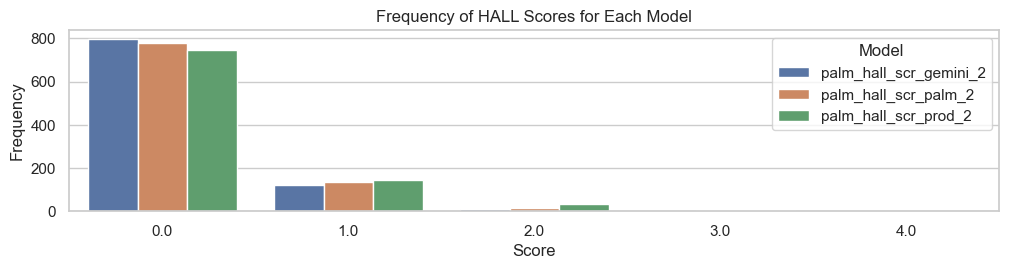

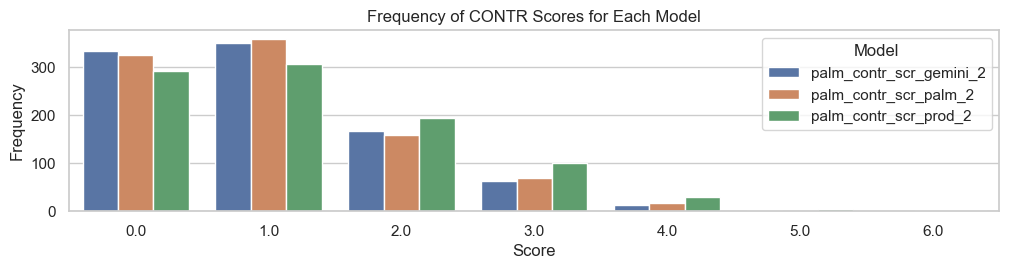

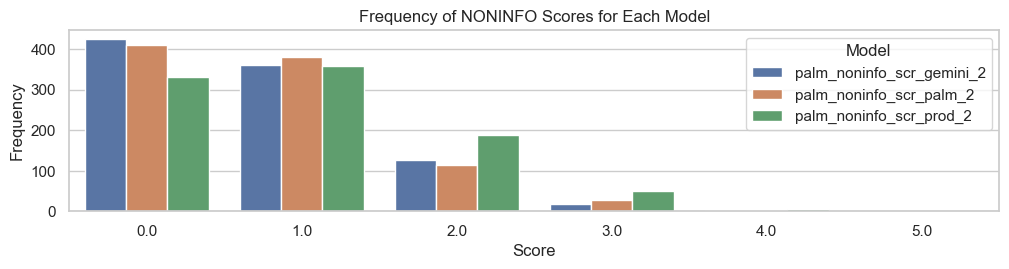

In [ ]:
plot_score_distributions(df=df_palm, model=model, V=2)

As expected, the second version of the scores reflects the results of the first version, with the only difference that the number of correct summaries is higher.

In [ ]:
pd.DataFrame({
    'Summary': summaries,
    'Reduction Hallucination Score': [1-(df_palm[f"{model}_hall_scr_{SUMM1}_2"].mean() / df_palm[f"{model}_hall_scr_{S}_1"].mean()) for S in summaries],
    'Reduction Contradiction Score': [1-(df_palm[f"{model}_contr_scr_{SUMM1}_2"].mean() / df_palm[f"{model}_contr_scr_{S}_1"].mean()) for S in summaries],
    'Reduction Noninformativeness Score': [1-(df_palm[f"{model}_noninfo_scr_{SUMM1}_2"].mean() / df_palm[f"{model}_noninfo_scr_{S}_1"].mean()) for S in summaries]
})

,Summary,Reduction Hallucination Score,Reduction Contradiction Score,Reduction Noninformativeness Score
0,prod,0.413203,0.0,0.312642
1,palm,0.470238,0.0,0.293347
2,gemini,0.511401,0.0,0.300721


Considering the difference between the two versions of the scores as the proportion of negligible errors, we can see that Gemini is the most accurate and consistent model of summarization.

### t-tests

In [20]:
alpha = 0.05

# Hallucination Score - V1
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_hall_scr_{SUMM1}_1"], df_palm[f"{model}_hall_scr_{SUMM2}_1"])
print("""\nHallucination Score - V1:
H0: PROD = PALM
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_hall_scr_{SUMM2}_1"], df_palm[f"{model}_hall_scr_{SUMM3}_1"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")  

# Hallucination Score - V2
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_hall_scr_{SUMM1}_2"], df_palm[f"{model}_hall_scr_{SUMM2}_2"])
print("""\n\nHallucination Score - V2:
H0: PROD = PALM
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_hall_scr_{SUMM2}_2"], df_palm[f"{model}_hall_scr_{SUMM3}_2"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print(f"Different distributions (reject H0)")
else:
    print(f"Same distributions (fail to reject H0)")
    


Hallucination Score - V1:
H0: PROD = PALM
p-value: 0.01608
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.27994
Same distributions (fail to reject H0)


Hallucination Score - V2:
H0: PROD = PALM
p-value: 0.00556
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.13929
Same distributions (fail to reject H0)


The new summaries are better than the summaries in production, as the p-value is lower than 0.05.
No difference between the two versions of the new summaries is noticed in terms of hallucinations.

In [21]:
alpha = 0.05

# Contradiction Score - V1
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_contr_scr_{SUMM1}_1"], df_palm[f"{model}_contr_scr_{SUMM2}_1"])
print("""\nContradiction Score - V1:
H0: PROD = PALM
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_contr_scr_{SUMM2}_1"], df_palm[f"{model}_contr_scr_{SUMM3}_1"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")  

# Contradiction Score - V2
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_contr_scr_{SUMM1}_2"], df_palm[f"{model}_contr_scr_{SUMM2}_2"])
print("""\n\nContradiction Score - V2:
H0: PROD = PALM
print("p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_contr_scr_{SUMM2}_2"], df_palm[f"{model}_contr_scr_{SUMM3}_2"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print(f"Different distributions (reject H0)")
else:
    print(f"Same distributions (fail to reject H0)")
    


Contradiction Score - V1:
H0: PROD = PALM
p-value: 0.00007
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.56870
Same distributions (fail to reject H0)


Contradiction Score - V2:
H0: PROD = PALM
print("p-value: 0.00007
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.56870
Same distributions (fail to reject H0)


Same as before, the new summaries are better than the summaries in production, as the p-value is lower than 0.05 in terms of contradictions.
No difference between the two versions of the new summaries is noticed in terms of contradictions.

In [22]:
alpha = 0.05

# Noninformativeness Score - V1
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_noninfo_scr_{SUMM1}_1"], df_palm[f"{model}_noninfo_scr_{SUMM2}_1"])
print("""\nNoninformativeness Score - V1:
H0: PROD = PALM
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_noninfo_scr_{SUMM2}_1"], df_palm[f"{model}_noninfo_scr_{SUMM3}_1"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")  

# Noninformativeness Score - V2
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_noninfo_scr_{SUMM1}_2"], df_palm[f"{model}_noninfo_scr_{SUMM2}_2"])
print("""\n\nNoninformativeness Score - V2:
H0: PROD = PALM
print("p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_palm[f"{model}_noninfo_scr_{SUMM2}_2"], df_palm[f"{model}_noninfo_scr_{SUMM3}_2"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print(f"Different distributions (reject H0)")
else:
    print(f"Same distributions (fail to reject H0)")
    


Noninformativeness Score - V1:
H0: PROD = PALM
p-value: 0.00000
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.60276
Same distributions (fail to reject H0)


Noninformativeness Score - V2:
H0: PROD = PALM
print("p-value: 0.00000
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.52293
Same distributions (fail to reject H0)


Same pattern as before holds for noninformativeness.

## Second Evaluation (run by Gemini)

In [ ]:
model = 'gemini'

### Comprehensible

In [ ]:
df_gemini = gemini_call_mt(
    df,
    column_text='conv',
    column_questions='conv',
    column_output=f'{model}_comprehensible',
    prompt=PROMPT_COMPREHENSIBLE,
    model=model_palm,
    model_config=model_config,
    goal='comprehensible'
)

In [ ]:
df_gemini[f'{model}_comprehensible_json'] = df_gemini[f'{model}_comprehensible'].apply(extract_json)
df_gemini = df_gemini[df_gemini[f"{model}_comprehensible_json"] != "ERROR"]
df_gemini[f'{model}_comprehensible_json'] = df_gemini[f'{model}_comprehensible_json'].apply(lambda x: x['comprehensible'])
df_gemini[f'{model}_comprehensible_json'].value_counts()

gemini_comprehensible_json
Yes    961
No      36
Name: count, dtype: int64

### Question Generation

In [ ]:
columns = [
    "conv",
    SUMM1,
    SUMM2,
    SUMM3,
]

for col in columns:
    
    print(f"Generating questions from {col.upper()}")
    
    df_gemini = gemini_call_mt(df_gemini,
                      column_text = col,
                      column_questions = col,
                      column_output = f'{model}_output_from_{col}',
                      prompt = QUEST_PROMPT,
                      model = model_palm,
                      model_config = model_config,
                      goal = 'generate_questions')
    
    df_gemini[f'{model}_quest_from_{col}'] = df_gemini[f'{model}_output_from_{col}'].apply(extract_json)
    df_gemini = df_gemini[df_gemini[f'{model}_quest_from_{col}']!="ERROR"]
    df_gemini[f'{model}_quest_from_{col}'] = df_gemini[f'{model}_quest_from_{col}'].apply(lambda x: x['questions'])

### Answer Generation

In [ ]:
source_and_questions = [
    ("conv", "conv"),
    (SUMM1, "conv"),
    (SUMM2, "conv"),
    (SUMM3, "conv"),
    ("conv", SUMM1),
    (SUMM1, SUMM1),
    ("conv", SUMM2),
    (SUMM2, SUMM2),
    ("conv", SUMM3),
    (SUMM3, SUMM3),
]

for text, source in source_and_questions:
    
    print(f"\nGenerating answers for {text.upper()} from {source.upper()}")
    
    df_gemini = gemini_call_mt(
        df_gemini,
        column_text = text,
        column_questions = f"{model}_quest_from_{source}",
        column_output = f"{model}_answ_{text}_from_{source}",
        threads = THREADS,
        prompt = ANSW_PROMPT,
        model = model_palm,
        model_config = model_config,
        goal = 'generate_answers'
    )
    
    df_gemini[f'{model}_answ_{text}_from_{source}'] = df_gemini[f'{model}_answ_{text}_from_{source}'].apply(lambda x: extract_json(x))
    df_gemini = df_gemini[df_gemini[f'{model}_answ_{text}_from_{source}']!="ERROR"]
    df_gemini[f'{model}_answ_{text}_from_{source}'] = df_gemini[f'{model}_answ_{text}_from_{source}'].apply(lambda x: x['answers'])

### Score Computation

In [ ]:
V = 1

for S in summaries:
    df_gemini[f"{model}_hall_scr_{S}_{V}"] = df_gemini.apply(lambda row: compute_hallucination_score(row, model, S, V=V), axis=1)
    df_gemini[f"{model}_contr_scr_{S}_{V}"] = df_gemini.apply(lambda row: compute_contradiction_score(row, model, S), axis=1)
    df_gemini[f"{model}_noninfo_scr_{S}_{V}"] = df_gemini.apply(lambda row: compute_noninformativeness_score(row, model, S, V=V), axis=1)
    
pd.DataFrame({
    'Summaries': summaries,
    'Average Hallucination Score': [df_gemini[f"{model}_hall_scr_{S}_{V}"].mean() for S in summaries], 
    'Average Contradiction Score': [df_gemini[f"{model}_contr_scr_{S}_{V}"].mean() for S in summaries],
    'Average Noninformativeness Score': [df_gemini[f"{model}_noninfo_scr_{S}_{V}"].mean() for S in summaries]
})

,Summary,Average Hallucination Score,Average Contradiction Score,Average Noninformativeness Score
0,prod,0.477054,0.625400,1.665955
1,palm,0.357524,0.561366,1.219851
2,gemini,0.264674,0.495197,1.010672


In [ ]:
df_gemini[
    [
        f'{model}_hall_scr_{SUMM1}_{V}',
        f'{model}_hall_scr_{SUMM2}_{V}',
        f'{model}_hall_scr_{SUMM3}_{V}',
        f'{model}_contr_scr_{SUMM1}_{V}',
        f'{model}_contr_scr_{SUMM2}_{V}',
        f'{model}_contr_scr_{SUMM3}_{V}',
        f'{model}_noninfo_scr_{SUMM1}_{V}',
        f'{model}_noninfo_scr_{SUMM2}_{V}',
        f'{model}_noninfo_scr_{SUMM3}_{V}'
    ]
].describe()

,gemini_hall_scr_prod_1,gemini_hall_scr_palm_1,gemini_hall_scr_gemini_1,gemini_contr_scr_prod_1,gemini_contr_scr_palm_1,gemini_contr_scr_gemini_1,gemini_noninfo_scr_prod_1,gemini_noninfo_scr_palm_1,gemini_noninfo_scr_gemini_1
count,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000
mean,0.477054,0.357524,0.264674,0.625400,0.561366,0.495197,1.665955,1.219851,1.010672
std,0.735077,0.644859,0.539429,0.826585,0.797111,0.742648,1.196703,1.061521,0.956251
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000
max,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,6.000000,7.000000,5.000000


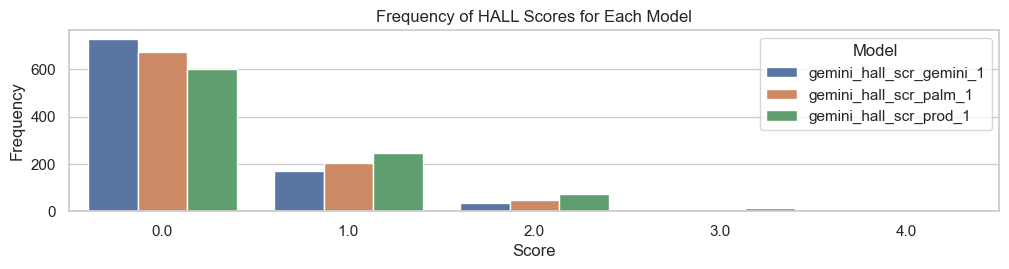

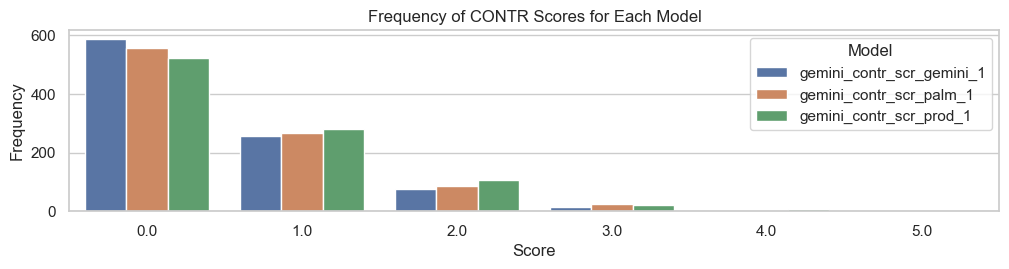

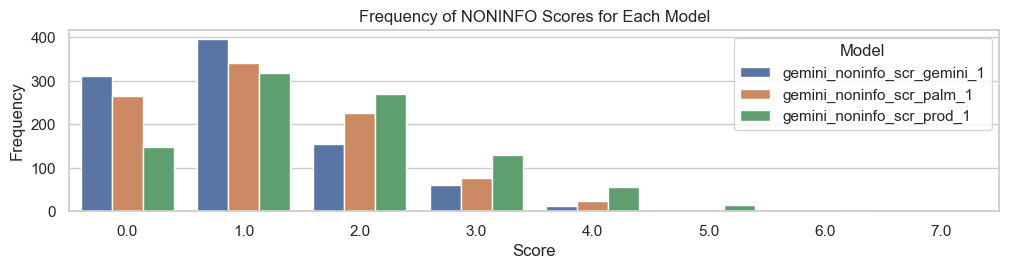

In [ ]:
plot_score_distributions(df=df_gemini, model=model)

If we use Gemini as evaluator, the results are in line with the results obtained using PaLM as evaluator. However, Gemini seems to find more consistent summaries and also the summaries generated with Gemini seem to be even more correct and consistent in this evaluation.

This may hint that PaLM is hallucinating or contradicting itself even in the evaluations steps.

In [ ]:
V = 2

for S in summaries:
    df_gemini[f"{model}_hall_scr_{S}_{V}"] = df_gemini.apply(lambda row: compute_hallucination_score(row, model, S, V=V), axis=1)
    df_gemini[f"{model}_contr_scr_{S}_{V}"] = df_gemini.apply(lambda row: compute_contradiction_score(row, model, S), axis=1)
    df_gemini[f"{model}_noninfo_scr_{S}_{V}"] = df_gemini.apply(lambda row: compute_noninformativeness_score(row, model, S, V=V), axis=1)

pd.DataFrame({
    'Summaries': summaries,
    'Average Hallucination Score': [df_gemini[f"{model}_hall_scr_{S}_{V}"].mean() for S in summaries], 
    'Average Contradiction Score': [df_gemini[f"{model}_contr_scr_{S}_{V}"].mean() for S in summaries],
    'Average Noninformativeness Score': [df_gemini[f"{model}_noninfo_scr_{S}_{V}"].mean() for S in summaries]
})

,Summary,Average Hallucination Score,Average Contradiction Score,Average Noninformativeness Score
0,prod,0.348986,0.625400,1.225187
1,palm,0.234792,0.561366,0.877268
2,gemini,0.156884,0.495197,0.713981


In [ ]:
df_gemini[
    [
        f'{model}_hall_scr_{SUMM1}_{V}',
        f'{model}_hall_scr_{SUMM2}_{V}',
        f'{model}_hall_scr_{SUMM3}_{V}',
        f'{model}_contr_scr_{SUMM1}_{V}',
        f'{model}_contr_scr_{SUMM2}_{V}',
        f'{model}_contr_scr_{SUMM3}_{V}',
        f'{model}_noninfo_scr_{SUMM1}_{V}',
        f'{model}_noninfo_scr_{SUMM2}_{V}',
        f'{model}_noninfo_scr_{SUMM3}_{V}'
    ]
].describe()

,gemini_hall_scr_prod_2,gemini_hall_scr_palm_2,gemini_hall_scr_gemini_2,gemini_contr_scr_prod_2,gemini_contr_scr_palm_2,gemini_contr_scr_gemini_2,gemini_noninfo_scr_prod_2,gemini_noninfo_scr_palm_2,gemini_noninfo_scr_gemini_2
count,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000
mean,0.348986,0.234792,0.156884,0.625400,0.561366,0.495197,1.225187,0.877268,0.713981
std,0.636229,0.521284,0.394863,0.826585,0.797111,0.742648,1.035423,0.921541,0.808176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000
max,4.000000,4.000000,2.000000,4.000000,5.000000,5.000000,6.000000,5.000000,4.000000


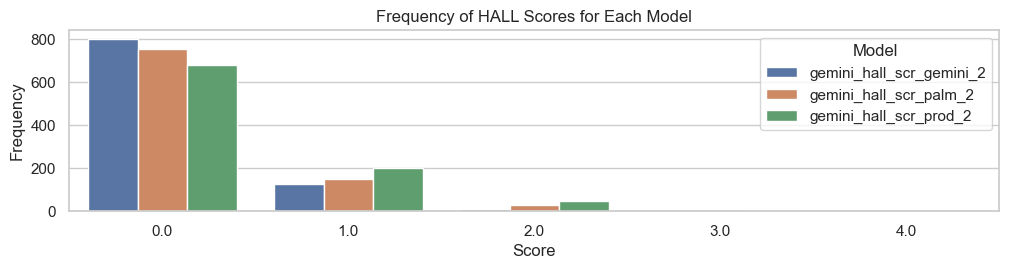

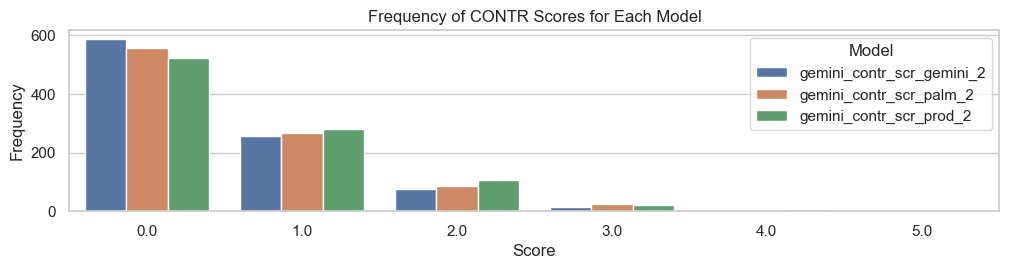

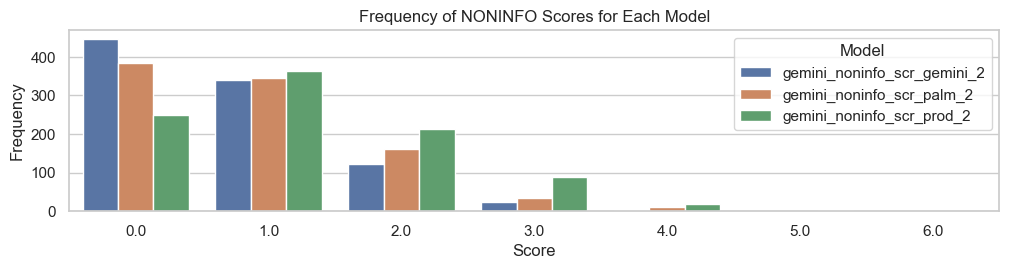

In [ ]:
plot_score_distributions(df=df_gemini, model=model, V=2)

As said for PaLM, the second version of the scores reflects the results of the first version, with the only difference that the number of correct summaries is higher, with the summaries generated by Gemini being the most consistent.

In [ ]:
pd.DataFrame({
    'Summary': summaries,
    'Reduction Hallucination Score': [1-(df_gemini[f"{model}_hall_scr_{SUMM1}_2"].mean() / df_gemini[f"{model}_hall_scr_{S}_1"].mean()) for S in summaries],
    'Reduction Contradiction Score': [1-(df_gemini[f"{model}_contr_scr_{SUMM1}_2"].mean() / df_gemini[f"{model}_contr_scr_{S}_1"].mean()) for S in summaries],
    'Reduction Noninformativeness Score': [1-(df_gemini[f"{model}_noninfo_scr_{SUMM1}_2"].mean() / df_gemini[f"{model}_noninfo_scr_{S}_1"].mean()) for S in summaries]
})

,Summary,Reduction Hallucination Score,Reduction Contradiction Score,Reduction Noninformativeness Score
0,prod,0.268456,0.0,0.264574
1,palm,0.343284,0.0,0.280840
2,gemini,0.407258,0.0,0.293559


Even here the difference between the two versions of the scores is considered as the proportion of negligible errors, and we can see that Gemini is the most accurate and consistent model of summarization.

### t-tests

In [24]:
alpha = 0.05

# Hallucination Score - V1
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_hall_scr_{SUMM1}_1"], df_gemini[f"{model}_hall_scr_{SUMM2}_1"])
print("""\nHallucination Score - V1:
H0: PROD = PALM
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_hall_scr_{SUMM2}_1"], df_gemini[f"{model}_hall_scr_{SUMM3}_1"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")  

# Hallucination Score - V2
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_hall_scr_{SUMM1}_2"], df_gemini[f"{model}_hall_scr_{SUMM2}_2"])
print("""\n\nHallucination Score - V2:
H0: PROD = PALM
print("p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_hall_scr_{SUMM2}_2"], df_gemini[f"{model}_hall_scr_{SUMM3}_2"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print(f"Different distributions (reject H0)")
else:
    print(f"Same distributions (fail to reject H0)")
    


Hallucination Score - V1:
H0: PROD = PALM
p-value: 0.00019
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.00074
Different distributions (reject H0)


Hallucination Score - V2:
H0: PROD = PALM
print("p-value: 0.00002
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.00027
Different distributions (reject H0)


According to this evaluation, the new summaries are better than the summaries in production, as the p-value is lower than 0.05. Furthermore, the new summaries generated by Gemini are even better than the new summaries generated by PaLM, as the p-value is lower than 0.05 in terms of hallucinations.

In [25]:
alpha = 0.05

# Contradiction Score - V1
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_contr_scr_{SUMM1}_1"], df_gemini[f"{model}_contr_scr_{SUMM2}_1"])
print("""\nContradiction Score - V1:
H0: PROD = PALM
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_contr_scr_{SUMM2}_1"], df_gemini[f"{model}_contr_scr_{SUMM3}_1"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")  

# Contradiction Score - V2
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_contr_scr_{SUMM1}_2"], df_gemini[f"{model}_contr_scr_{SUMM2}_2"])
print("""\n\nContradiction Score - V2:
H0: PROD = PALM
print("p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_contr_scr_{SUMM2}_2"], df_gemini[f"{model}_contr_scr_{SUMM3}_2"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print(f"Different distributions (reject H0)")
else:
    print(f"Same distributions (fail to reject H0)")
    


Contradiction Score - V1:
H0: PROD = PALM
p-value: 0.08800
Same distributions (fail to reject H0)

H0: PALM = GEMINI
p-value: 0.06316
Same distributions (fail to reject H0)


Contradiction Score - V2:
H0: PROD = PALM
print("p-value: 0.08800
Same distributions (fail to reject H0)

H0: PALM = GEMINI
p-value: 0.06316
Same distributions (fail to reject H0)


In terms of contradictions, no improvement is noticed between the new summaries and the summaries in production, as the p-value is higher than 0.05.

In [26]:
alpha = 0.05

# Noninformativeness Score - V1
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_noninfo_scr_{SUMM1}_1"], df_gemini[f"{model}_noninfo_scr_{SUMM2}_1"])
print("""\nNoninformativeness Score - V1:
H0: PROD = PALM
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_noninfo_scr_{SUMM2}_1"], df_gemini[f"{model}_noninfo_scr_{SUMM3}_1"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")  

# Noninformativeness Score - V2
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_noninfo_scr_{SUMM1}_2"], df_gemini[f"{model}_noninfo_scr_{SUMM2}_2"])
print("""\n\nNoninformativeness Score - V2:
H0: PROD = PALM
print("p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_gemini[f"{model}_noninfo_scr_{SUMM2}_2"], df_gemini[f"{model}_noninfo_scr_{SUMM3}_2"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print(f"Different distributions (reject H0)")
else:
    print(f"Same distributions (fail to reject H0)")
    


Noninformativeness Score - V1:
H0: PROD = PALM
p-value: 0.00000
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.00001
Different distributions (reject H0)


Noninformativeness Score - V2:
H0: PROD = PALM
print("p-value: 0.00000
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.00005
Different distributions (reject H0)


For informativeness, the new summaries are better than the summaries in production, as the p-value is lower than 0.05. As for hallucinations, the new summaries generated by Gemini are even better than the new summaries generated by PaLM, as the p-value is lower than 0.05.

## Third Evaluation (run by Gemini)

In this evaluation, Gemini is asked to provide both the questions and the answers for every text provided, lightening the workload of the model.

In [27]:
model = 'qa'

### Question Generation

In [ ]:
df_qa = df.copy()

In [ ]:
columns = [
    "conv",
    SUMM1,
    SUMM2,
    SUMM3,
]

for col in columns:
    
    print(f"\nGenerating questions from {col.upper()}")
    
    df_qa = gemini_call_mt(
        df_qa,
        column_text = col,
        column_questions = col,
        column_output = f'{model}_output_from_{col}',
        prompt = QA_PROMPT,
        model = model_palm,
        model_config = model_config,
        goal = 'generate_questions'
    )
    
    df_qa[f'{model}_output_from_{col}'] = df_qa[f'{model}_output_from_{col}'].apply(extract_json)
    df_qa = df_qa[df_qa[f'{model}_output_from_{col}']!="ERROR"]
    df_qa[f'{model}_quest_from_{col}'] = df_qa[f'{model}_output_from_{col}'].apply(lambda x: x['questions'])
    df_qa[f'{model}_answ_{col}_from_{col}'] = df_qa[f'{model}_output_from_{col}'].apply(lambda x: x['answers'])

### Answer Generation

In [ ]:
source_and_questions = [
    (SUMM1, "conv"),
    (SUMM2, "conv"),
    (SUMM3, "conv"),
    ("conv", SUMM1),
    ("conv", SUMM2),
    ("conv", SUMM3),
]

for text, source in source_and_questions:
    
    print(f"\nGenerating answers for {text.upper()} from {source.upper()}")
    
    df_qa = gemini_call_mt(
        df_qa,
        column_text = text,
        column_questions = f"{model}_quest_from_{source}",
        column_output = f"{model}_answ_{text}_from_{source}",
        threads = THREADS,
        prompt = ANSW_PROMPT,
        model = model_palm,
        model_config = model_config,
        goal = 'generate_answers'
    )
    
    
    df_qa[f'{model}_answ_{text}_from_{source}'] = df_qa[f'{model}_answ_{text}_from_{source}'].apply(lambda x: extract_json(x))
    df_qa = df_qa[df_qa[f'{model}_answ_{text}_from_{source}']!="ERROR"]
    df_qa[f'{model}_answ_{text}_from_{source}'] = df_qa[f'{model}_answ_{text}_from_{source}'].apply(lambda x: x['answers'])
    
    print(df.shape[0])

### Score Computation

In [ ]:
V = 1

for S in summaries:
    df_qa[f"{model}_hall_scr_{S}_{V}"] = df_qa.apply(lambda row: compute_hallucination_score(row, model, S, V=V), axis=1)
    df_qa[f"{model}_contr_scr_{S}_{V}"] = df_qa.apply(lambda row: compute_contradiction_score(row, model, S), axis=1)
    df_qa[f"{model}_noninfo_scr_{S}_{V}"] = df_qa.apply(lambda row: compute_noninformativeness_score(row, model, S, V=V), axis=1)

pd.DataFrame({
    'Summary': summaries,
    'Average Hallucination Score': [df_qa[f"{model}_hall_scr_{S}_{V}"].mean() for S in summaries], 
    'Average Contradiction Score': [df_qa[f"{model}_contr_scr_{S}_{V}"].mean() for S in summaries],
    'Average Noninformativeness Score': [df_qa[f"{model}_noninfo_scr_{S}_{V}"].mean() for S in summaries]
})

,Summary,Average Hallucination Score,Average Contradiction Score,Average Noninformativeness Score
0,prod,0.483146,0.750766,2.201226
1,palm,0.444331,0.693565,1.678243
2,gemini,0.362615,0.672114,1.435138


In [ ]:
df_qa[
    [
        f'{model}_hall_scr_{SUMM1}_{V}',
        f'{model}_hall_scr_{SUMM2}_{V}',
        f'{model}_hall_scr_{SUMM3}_{V}',
        f'{model}_contr_scr_{SUMM1}_{V}',
        f'{model}_contr_scr_{SUMM2}_{V}',
        f'{model}_contr_scr_{SUMM3}_{V}',
        f'{model}_noninfo_scr_{SUMM1}_{V}',
        f'{model}_noninfo_scr_{SUMM2}_{V}',
        f'{model}_noninfo_scr_{SUMM3}_{V}'
    ]
].describe()

,qa_hall_scr_prod_1,qa_hall_scr_palm_1,qa_hall_scr_gemini_1,qa_contr_scr_prod_1,qa_contr_scr_palm_1,qa_contr_scr_gemini_1,qa_noninfo_scr_prod_1,qa_noninfo_scr_palm_1,qa_noninfo_scr_gemini_1
count,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000
mean,0.483146,0.444331,0.362615,0.750766,0.693565,0.672114,2.201226,1.678243,1.435138
std,0.758370,0.676600,0.616965,0.879898,0.882730,0.831234,1.405277,1.281314,1.141623
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,2.000000
max,5.000000,3.000000,4.000000,4.000000,6.000000,5.000000,8.000000,7.000000,6.000000


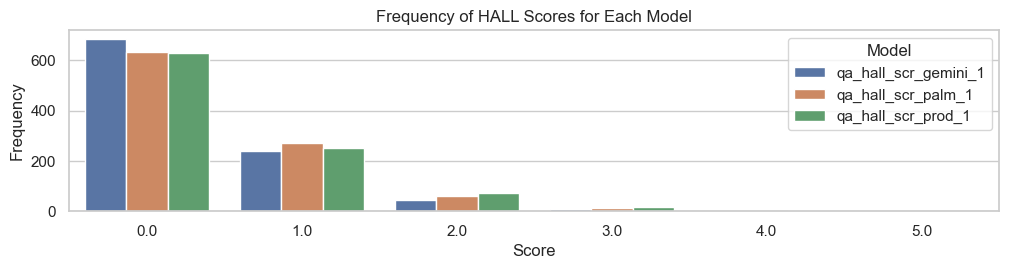

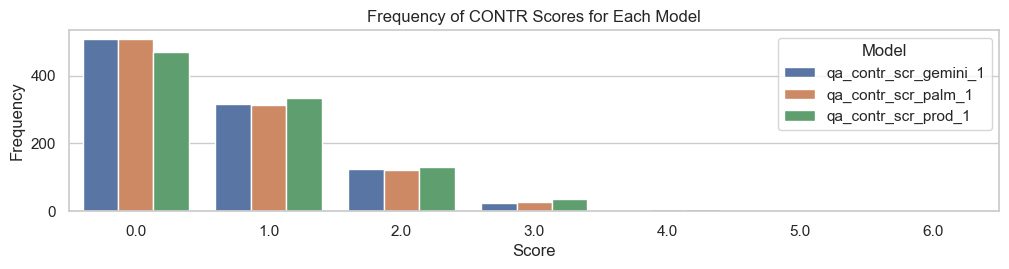

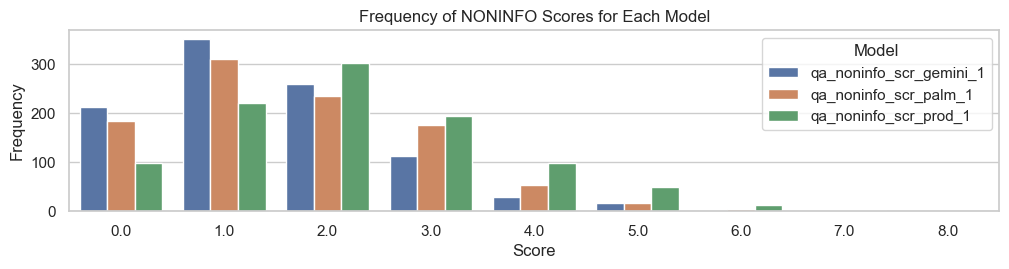

In [ ]:
plot_score_distributions(df=df_qa, model=model)

Using Gemini as evaluator and the Q&A in the same step, the results are in line with the results obtained in the previous steps, however the scores are a bit inflated, especially the number of noninformativeness.

A further inspection of the results may be needed to assess whether this approach is beneficial or not.

In [ ]:
V = 2

for S in summaries:
    df_qa[f"{model}_hall_scr_{S}_{V}"] = df_qa.apply(lambda row: compute_hallucination_score(row, model, S, V=V), axis=1)
    df_qa[f"{model}_contr_scr_{S}_{V}"] = df_qa.apply(lambda row: compute_contradiction_score(row, model, S), axis=1)
    df_qa[f"{model}_noninfo_scr_{S}_{V}"] = df_qa.apply(lambda row: compute_noninformativeness_score(row, model, S, V=V), axis=1)

pd.DataFrame({
    'Summary': summaries,
    'Average Hallucination Score': [df_qa[f"{model}_hall_scr_{S}_{V}"].mean() for S in summaries], 
    'Average Contradiction Score': [df_qa[f"{model}_contr_scr_{S}_{V}"].mean() for S in summaries],
    'Average Noninformativeness Score': [df_qa[f"{model}_noninfo_scr_{S}_{V}"].mean() for S in summaries]
})

,Summary,Average Hallucination Score,Average Contradiction Score,Average Noninformativeness Score
0,prod,0.268641,0.750766,1.277835
1,palm,0.226762,0.693565,0.974464
2,gemini,0.141982,0.672114,0.804903


In [ ]:
df_qa[
    [
        f'{model}_hall_scr_{SUMM1}_{V}',
        f'{model}_hall_scr_{SUMM2}_{V}',
        f'{model}_hall_scr_{SUMM3}_{V}',
        f'{model}_contr_scr_{SUMM1}_{V}',
        f'{model}_contr_scr_{SUMM2}_{V}',
        f'{model}_contr_scr_{SUMM3}_{V}',
        f'{model}_noninfo_scr_{SUMM1}_{V}',
        f'{model}_noninfo_scr_{SUMM2}_{V}',
        f'{model}_noninfo_scr_{SUMM3}_{V}'
    ]
].describe()

,qa_hall_scr_prod_2,qa_hall_scr_palm_2,qa_hall_scr_gemini_2,qa_contr_scr_prod_2,qa_contr_scr_palm_2,qa_contr_scr_gemini_2,qa_noninfo_scr_prod_2,qa_noninfo_scr_palm_2,qa_noninfo_scr_gemini_2
count,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000
mean,0.268641,0.226762,0.141982,0.750766,0.693565,0.672114,1.277835,0.974464,0.804903
std,0.570534,0.476073,0.398443,0.879898,0.882730,0.831234,1.089281,0.976389,0.879054
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000
max,4.000000,3.000000,3.000000,4.000000,6.000000,5.000000,8.000000,5.000000,4.000000


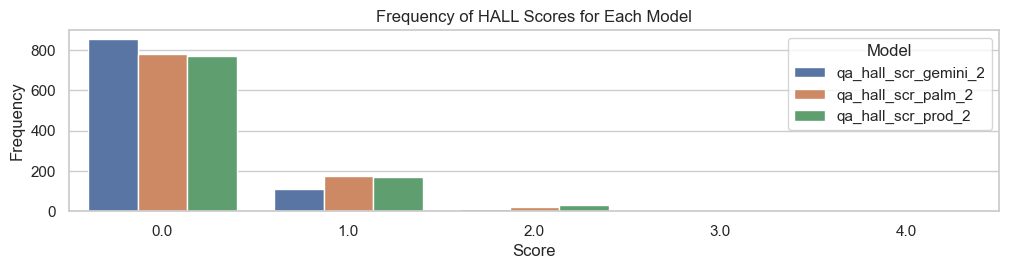

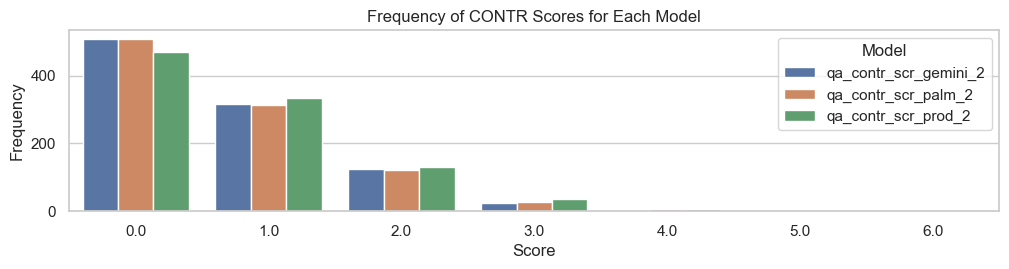

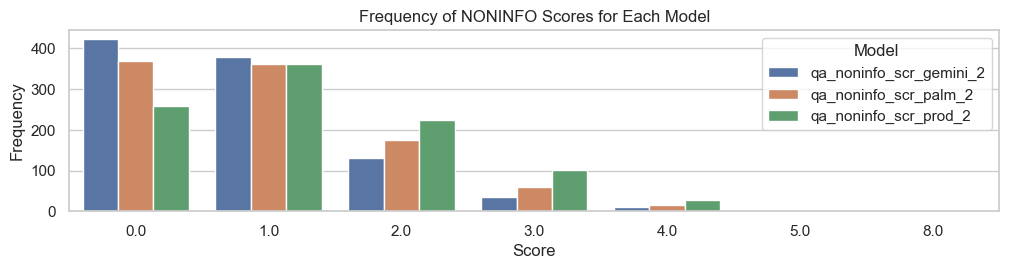

In [ ]:
plot_score_distributions(df=df_qa, model=model, V=2)

If we use the second computation method the scores return to be in line with the previous results, although a little bit higher.

In [ ]:
pd.DataFrame({
    'Summary': [SUMM1, SUMM2, SUMM3],
    'Reduction Hallucination Score': [1-(df_qa[f"{model}_hall_scr_{SUMM1}_2"].mean() / df_qa[f"{model}_hall_scr_{S}_1"].mean()) for S in summaries],
    'Reduction Contradiction Score': [1-(df_qa[f"{model}_contr_scr_{SUMM1}_2"].mean() / df_qa[f"{model}_contr_scr_{S}_1"].mean()) for S in summaries],
    'Reduction Noninformativeness Score': [1-(df_qa[f"{model}_noninfo_scr_{SUMM1}_2"].mean() / df_qa[f"{model}_noninfo_scr_{S}_1"].mean()) for S in summaries]
})

,Summary,Reduction Hallucination Score,Reduction Contradiction Score,Reduction Noninformativeness Score
0,prod,0.443975,0.0,0.419490
1,palm,0.489655,0.0,0.419355
2,gemini,0.608451,0.0,0.439146


### t-tests

In [28]:
alpha = 0.05

# Hallucination Score - V1
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_hall_scr_{SUMM1}_1"], df_qa[f"{model}_hall_scr_{SUMM2}_1"])
print("""\nHallucination Score - V1:
H0: PROD = PALM
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_hall_scr_{SUMM2}_1"], df_qa[f"{model}_hall_scr_{SUMM3}_1"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")  

# Hallucination Score - V2
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_hall_scr_{SUMM1}_2"], df_qa[f"{model}_hall_scr_{SUMM2}_2"])
print("""\n\nHallucination Score - V2:
H0: PROD = PALM
print("p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_hall_scr_{SUMM2}_2"], df_qa[f"{model}_hall_scr_{SUMM3}_2"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print(f"Different distributions (reject H0)")
else:
    print(f"Same distributions (fail to reject H0)")
    


Hallucination Score - V1:
H0: PROD = PALM
p-value: 0.23224
Same distributions (fail to reject H0)

H0: PALM = GEMINI
p-value: 0.00528
Different distributions (reject H0)


Hallucination Score - V2:
H0: PROD = PALM
print("p-value: 0.07798
Same distributions (fail to reject H0)

H0: PALM = GEMINI
p-value: 0.00002
Different distributions (reject H0)


According to this last evaluation, only the summaries generated by Gemini are better than the summaries in production for hallucinations.

In [29]:
alpha = 0.05

# Contradiction Score - V1
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_contr_scr_{SUMM1}_1"], df_qa[f"{model}_contr_scr_{SUMM2}_1"])
print("""\nContradiction Score - V1:
H0: PROD = PALM
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_contr_scr_{SUMM2}_1"], df_qa[f"{model}_contr_scr_{SUMM3}_1"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")  

# Contradiction Score - V2
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_contr_scr_{SUMM1}_2"], df_qa[f"{model}_contr_scr_{SUMM2}_2"])
print("""\n\nContradiction Score - V2:
H0: PROD = PALM
print("p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_contr_scr_{SUMM2}_2"], df_qa[f"{model}_contr_scr_{SUMM3}_2"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print(f"Different distributions (reject H0)")
else:
    print(f"Same distributions (fail to reject H0)")
    


Contradiction Score - V1:
H0: PROD = PALM
p-value: 0.15117
Same distributions (fail to reject H0)

H0: PALM = GEMINI
p-value: 0.57996
Same distributions (fail to reject H0)


Contradiction Score - V2:
H0: PROD = PALM
print("p-value: 0.15117
Same distributions (fail to reject H0)

H0: PALM = GEMINI
p-value: 0.57996
Same distributions (fail to reject H0)


The contradictions are not improved by the new summaries, as the p-value is higher than 0.05.

In [30]:
alpha = 0.05

# Noninformativeness Score - V1
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_noninfo_scr_{SUMM1}_1"], df_qa[f"{model}_noninfo_scr_{SUMM2}_1"])
print("""\nNoninformativeness Score - V1:
H0: PROD = PALM
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_noninfo_scr_{SUMM2}_1"], df_qa[f"{model}_noninfo_scr_{SUMM3}_1"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")  

# Noninformativeness Score - V2
# PROD VS PALM
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_noninfo_scr_{SUMM1}_2"], df_qa[f"{model}_noninfo_scr_{SUMM2}_2"])
print("""\n\nNoninformativeness Score - V2:
H0: PROD = PALM
print("p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

# PALM VS GEMINI
t_statistic, p_value = stats.ttest_ind(df_qa[f"{model}_noninfo_scr_{SUMM2}_2"], df_qa[f"{model}_noninfo_scr_{SUMM3}_2"])
print("""\nH0: PALM = GEMINI
p-value: {:.5f}""".format(p_value))
if p_value < alpha:
    print(f"Different distributions (reject H0)")
else:
    print(f"Same distributions (fail to reject H0)")
    


Noninformativeness Score - V1:
H0: PROD = PALM
p-value: 0.00000
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.00001
Different distributions (reject H0)


Noninformativeness Score - V2:
H0: PROD = PALM
print("p-value: 0.00000
Different distributions (reject H0)

H0: PALM = GEMINI
p-value: 0.00006
Different distributions (reject H0)


The informativeness is improved by the new summaries, as the p-value is lower than 0.05. The new summaries generated by Gemini are even better than the new summaries generated by PaLM, as the p-value is lower than 0.05 in terms of hallucinations.

## Merge all DataFrames

In [ ]:
df = pd.merge(
    df,
    df_palm[
        [
            "ConnectionID",
            "time_stamp",
            f'palm_comprehensible_json',
            f"palm_hall_scr_{SUMM1}_1",
            f"palm_hall_scr_{SUMM1}_2",
            f"palm_contr_scr_{SUMM1}_1",
            f"palm_contr_scr_{SUMM1}_2",
            f"palm_noninfo_scr_{SUMM1}_1",
            f"palm_noninfo_scr_{SUMM1}_2",
            f"palm_hall_scr_{SUMM2}_1",
            f"palm_hall_scr_{SUMM2}_2",
            f"palm_contr_scr_{SUMM2}_1",
            f"palm_contr_scr_{SUMM2}_2",
            f"palm_noninfo_scr_{SUMM2}_1",
            f"palm_noninfo_scr_{SUMM2}_2",
            f"palm_hall_scr_{SUMM3}_1",
            f"palm_hall_scr_{SUMM3}_2",
            f"palm_contr_scr_{SUMM3}_1",
            f"palm_contr_scr_{SUMM3}_2",
            f"palm_noninfo_scr_{SUMM3}_1",
            f"palm_noninfo_scr_{SUMM3}_2",
        ]
    ],
    on=['ConnectionID', 'time_stamp'],
    how='left'
)

In [ ]:
df = pd.merge(
    df,
    df_gemini[
        [
            "ConnectionID",
            "time_stamp",
            f'gemini_comprehensible_json',
            f"gemini_hall_scr_{SUMM1}_1",
            f"gemini_hall_scr_{SUMM1}_2",
            f"gemini_contr_scr_{SUMM1}_1",
            f"gemini_contr_scr_{SUMM1}_2",
            f"gemini_noninfo_scr_{SUMM1}_1",
            f"gemini_noninfo_scr_{SUMM1}_2",
            f"gemini_hall_scr_{SUMM2}_1",
            f"gemini_hall_scr_{SUMM2}_2",
            f"gemini_contr_scr_{SUMM2}_1",
            f"gemini_contr_scr_{SUMM2}_2",
            f"gemini_noninfo_scr_{SUMM2}_1",
            f"gemini_noninfo_scr_{SUMM2}_2",
            f"gemini_hall_scr_{SUMM3}_1",
            f"gemini_hall_scr_{SUMM3}_2",
            f"gemini_contr_scr_{SUMM3}_1",
            f"gemini_contr_scr_{SUMM3}_2",
            f"gemini_noninfo_scr_{SUMM3}_1",
            f"gemini_noninfo_scr_{SUMM3}_2",
        ]
    ],
    on=['ConnectionID', 'time_stamp'],
    how='left'
)

In [ ]:
df = pd.merge(
    df,
    df_qa[
        [
            "ConnectionID",
            "time_stamp",
            f"qa_hall_scr_{SUMM1}_1",
            f"qa_hall_scr_{SUMM1}_2",
            f"qa_contr_scr_{SUMM1}_1",
            f"qa_contr_scr_{SUMM1}_2",
            f"qa_noninfo_scr_{SUMM1}_1",
            f"qa_noninfo_scr_{SUMM1}_2",
            f"qa_hall_scr_{SUMM2}_1",
            f"qa_hall_scr_{SUMM2}_2",
            f"qa_contr_scr_{SUMM2}_1",
            f"qa_contr_scr_{SUMM2}_2",
            f"qa_noninfo_scr_{SUMM2}_1",
            f"qa_noninfo_scr_{SUMM2}_2",
            f"qa_hall_scr_{SUMM3}_1",
            f"qa_hall_scr_{SUMM3}_2",
            f"qa_contr_scr_{SUMM3}_1",
            f"qa_contr_scr_{SUMM3}_2",
            f"qa_noninfo_scr_{SUMM3}_1",
            f"qa_noninfo_scr_{SUMM3}_2",
        ]
    ],
    on=['ConnectionID', 'time_stamp'],
    how='left'
)

## Analysis of results

Once we run the evaluation of the summaries, we can analyze the results to check whether there are possible notable differences between the summaries generated by the models in the embeddings space.

We compute the cosine similarity between the summaries generated by the models and the summaries in production to understand whether the summaries are similar in the embeddings space.

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

convs_embeddings = model.encode(df[f'conv'].values)
summ1_embeddings = model.encode(df[f'{SUMM1}'].values)
summ2_embeddings = model.encode(df[f'{SUMM2}'].values)
summ3_embeddings = model.encode(df[f'{SUMM3}'].values)

In [ ]:
df['convs_embeddings'] = convs_embeddings.tolist()
df[f'{SUMM1}_embeddings'] = summ1_embeddings.tolist()
df[f'{SUMM2}_embeddings'] = summ2_embeddings.tolist()
df[f'{SUMM3}_embeddings'] = summ3_embeddings.tolist()

In [ ]:
df[f'cosine_similarity_{SUMM1}'] = df.apply(lambda x: cosine_similarity([x['convs_embeddings']], [x[f'{SUMM1}_embeddings']])[0][0], axis=1)
df[f'cosine_similarity_{SUMM2}'] = df.apply(lambda x: cosine_similarity([x['convs_embeddings']], [x[f'{SUMM2}_embeddings']])[0][0], axis=1)
df[f'cosine_similarity_{SUMM3}'] = df.apply(lambda x: cosine_similarity([x['convs_embeddings']], [x[f'{SUMM3}_embeddings']])[0][0], axis=1)

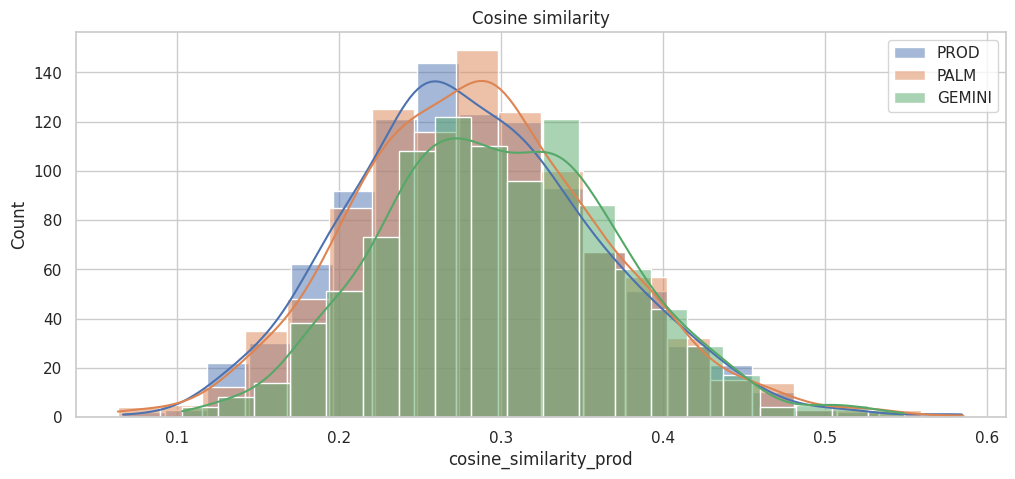

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(12, 5))

sns.histplot(df[f'cosine_similarity_{SUMM1}'], bins=20, alpha=.5, kde=True, ax=ax, label=f'{SUMM1.upper()}')
sns.histplot(df[f'cosine_similarity_{SUMM2}'], bins=20, alpha=.5, kde=True, ax=ax, label=f'{SUMM2.upper()}')
sns.histplot(df[f'cosine_similarity_{SUMM3}'], bins=20, alpha=.5, kde=True, ax=ax, label=f'{SUMM3.upper()}')
ax.set_title('Cosine similarity')
ax.legend()

plt.show()

The distribution of the cosine similarity shows a slightly better performance of the summaries generated by Gemini, even though this metrics is hard to take into consideration as the conversation are in Italian and the transctipts have a dialogue structure. 

In [ ]:
df['palm_comprehensible_bool'] = df['palm_comprehensible_json'].apply(lambda x: 1 if x=='Yes' else 0)
df['gemini_comprehensible_bool'] = df['gemini_comprehensible_json'].apply(lambda x: 1 if x=='Yes' else 0)

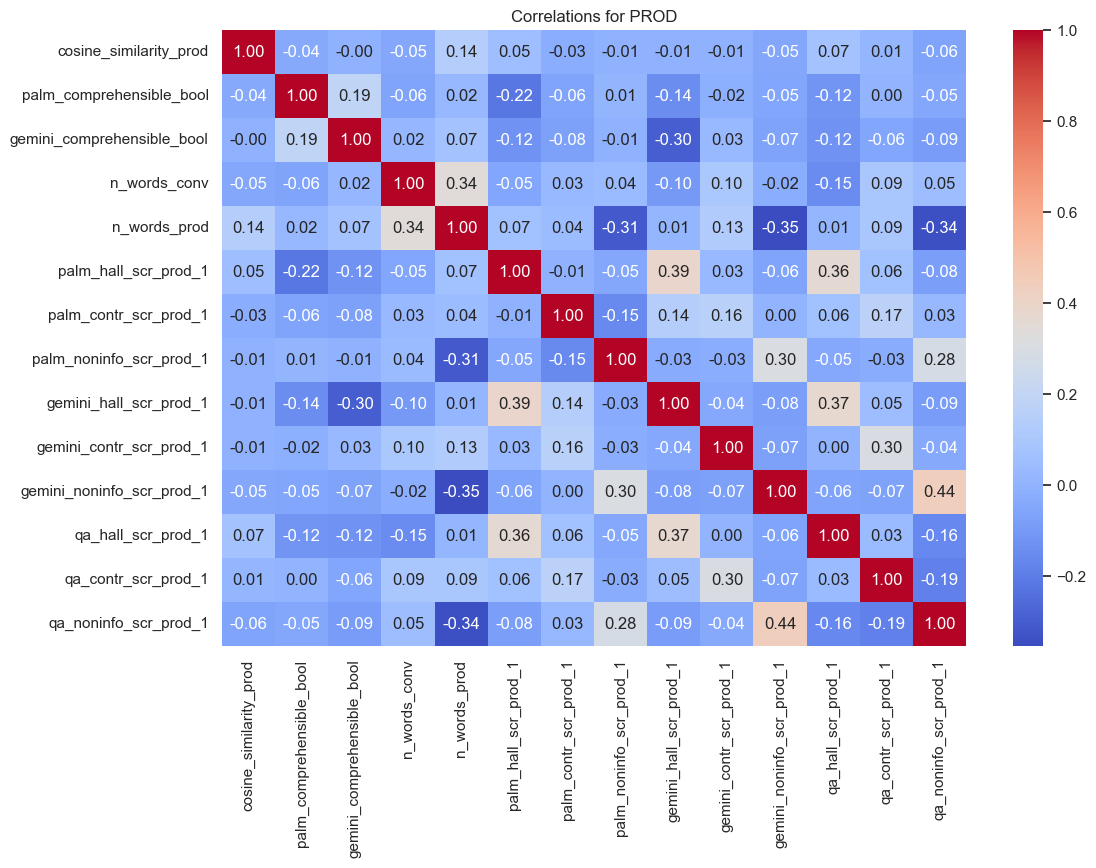

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    df[
        [
            f'cosine_similarity_{SUMM1}',
            f'palm_comprehensible_bool',
            f'gemini_comprehensible_bool',
            f'n_words_conv',
            f'n_words_{SUMM1}',
            f'palm_hall_scr_{SUMM1}_1',
            f'palm_contr_scr_{SUMM1}_1',
            f'palm_noninfo_scr_{SUMM1}_1',
            f'gemini_hall_scr_{SUMM1}_1',
            f'gemini_contr_scr_{SUMM1}_1',
            f'gemini_noninfo_scr_{SUMM1}_1',
            f'qa_hall_scr_{SUMM1}_1',
            f'qa_contr_scr_{SUMM1}_1',
            f'qa_noninfo_scr_{SUMM1}_1',
        ]
    ].corr(),
    annot = True,
    cmap = 'coolwarm',
    fmt='.2f'
)
plt.title(f'Correlations for {SUMM1.upper()}')
plt.show()

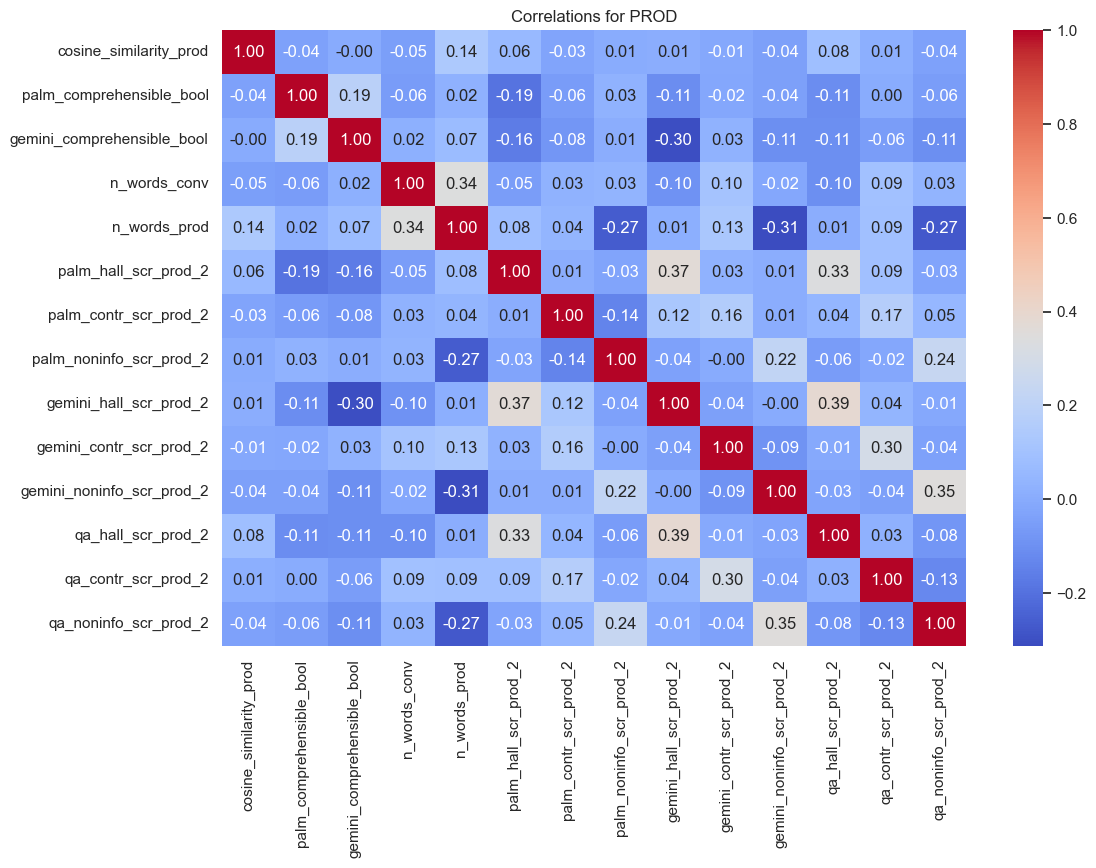

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    df[
        [
            f'cosine_similarity_{SUMM1}',
            f'palm_comprehensible_bool',
            f'gemini_comprehensible_bool',
            f'n_words_conv',
            f'n_words_{SUMM1}',
            f'palm_hall_scr_{SUMM1}_2',
            f'palm_contr_scr_{SUMM1}_2',
            f'palm_noninfo_scr_{SUMM1}_2',
            f'gemini_hall_scr_{SUMM1}_2',
            f'gemini_contr_scr_{SUMM1}_2',
            f'gemini_noninfo_scr_{SUMM1}_2',
            f'qa_hall_scr_{SUMM1}_2',
            f'qa_contr_scr_{SUMM1}_2',
            f'qa_noninfo_scr_{SUMM1}_2',
        ]
    ].corr(),
    annot = True,
    cmap = 'coolwarm',
    fmt='.2f'
)
plt.title(f'Correlations for {SUMM1.upper()}')
plt.show()

The strongest correlations are between the lengths of the summaries and the lengths of the conversations, as expected.

Also, when the conversation is not understandable, the summaries tend to be more hallucinating.

Lastly, are shorter summary is more likely to be noninformative.

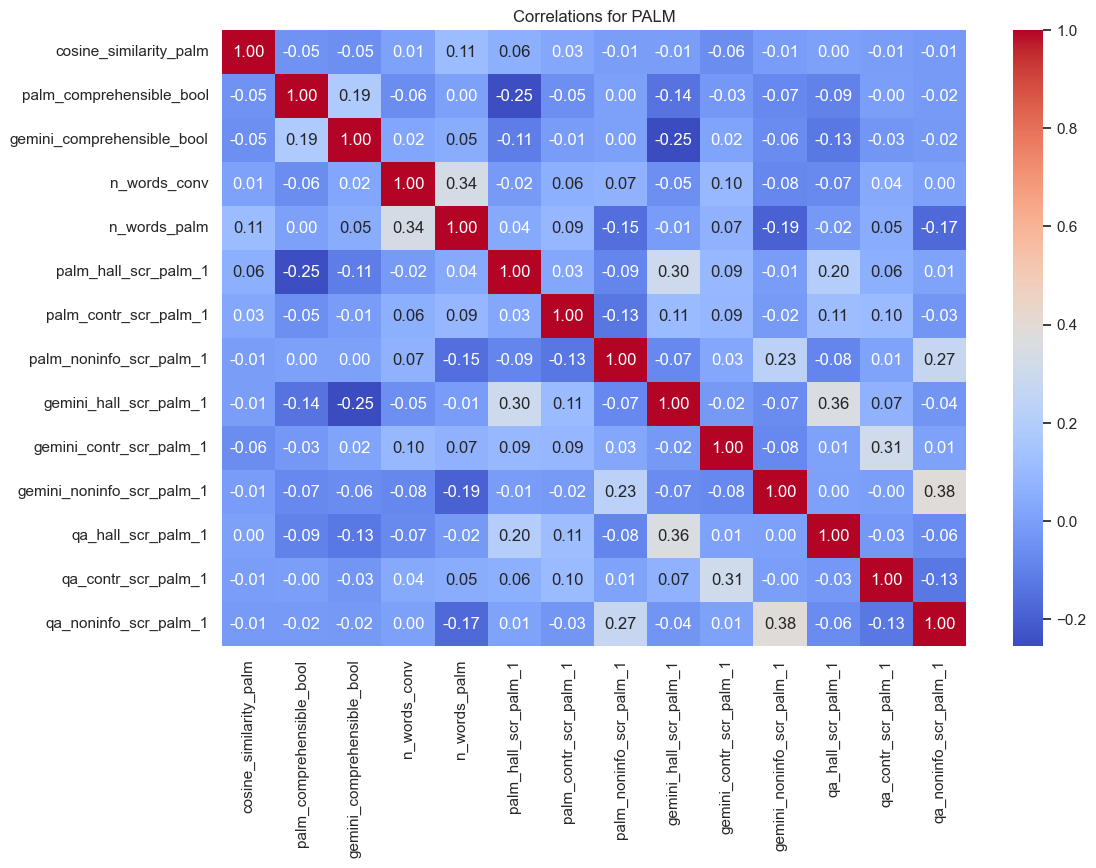

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    df[
        [
            f'cosine_similarity_{SUMM2}',
            f'palm_comprehensible_bool',
            f'gemini_comprehensible_bool',
            f'n_words_conv',
            f'n_words_{SUMM2}',
            f'palm_hall_scr_{SUMM2}_1',
            f'palm_contr_scr_{SUMM2}_1',
            f'palm_noninfo_scr_{SUMM2}_1',
            f'gemini_hall_scr_{SUMM2}_1',
            f'gemini_contr_scr_{SUMM2}_1',
            f'gemini_noninfo_scr_{SUMM2}_1',
            f'qa_hall_scr_{SUMM2}_1',
            f'qa_contr_scr_{SUMM2}_1',
            f'qa_noninfo_scr_{SUMM2}_1',
        ]
    ].corr(),
    annot = True,
    cmap = 'coolwarm',
    fmt='.2f'
)
plt.title(f'Correlations for {SUMM2.upper()}')
plt.show()

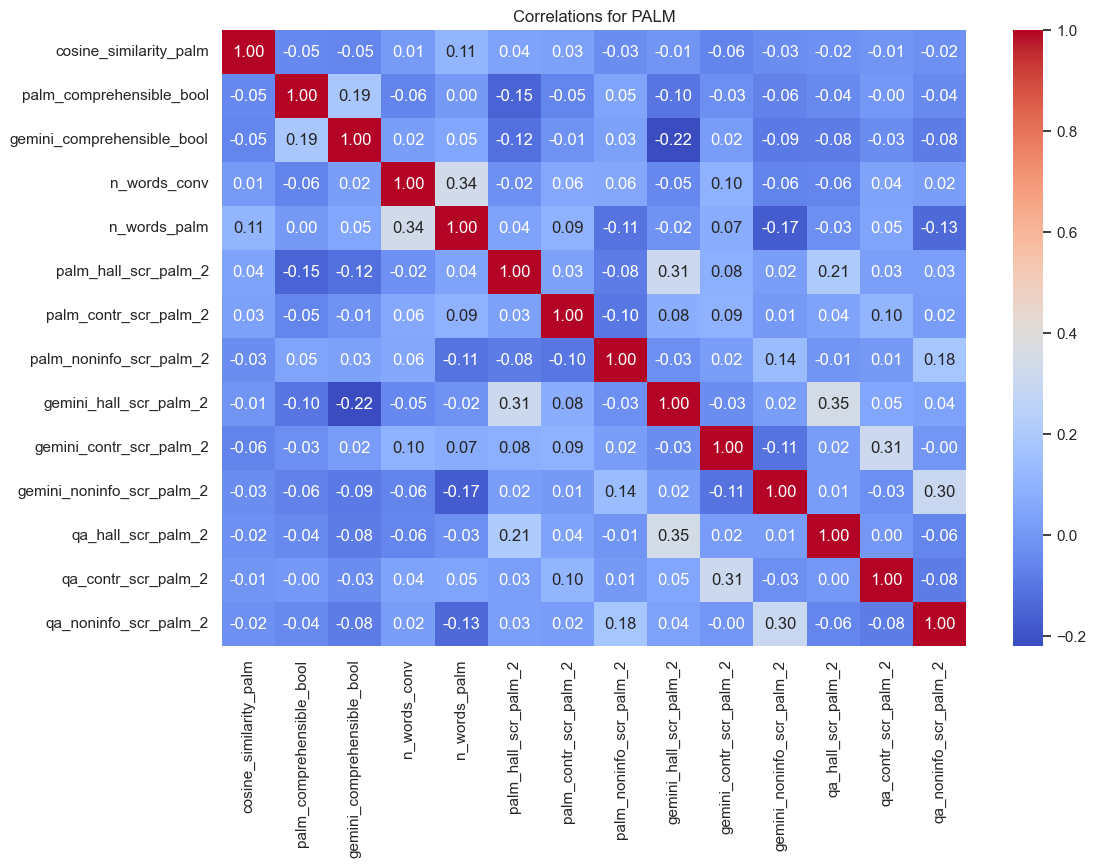

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    df[
        [
            f'cosine_similarity_{SUMM2}',
            f'palm_comprehensible_bool',
            f'gemini_comprehensible_bool',
            f'n_words_conv',
            f'n_words_{SUMM2}',
            f'palm_hall_scr_{SUMM2}_2',
            f'palm_contr_scr_{SUMM2}_2',
            f'palm_noninfo_scr_{SUMM2}_2',
            f'gemini_hall_scr_{SUMM2}_2',
            f'gemini_contr_scr_{SUMM2}_2',
            f'gemini_noninfo_scr_{SUMM2}_2',
            f'qa_hall_scr_{SUMM2}_2',
            f'qa_contr_scr_{SUMM2}_2',
            f'qa_noninfo_scr_{SUMM2}_2',
        ]
    ].corr(),
    annot = True,
    cmap = 'coolwarm',
    fmt='.2f'
)
plt.title(f'Correlations for {SUMM2.upper()}')
plt.show()

The same findings hold for the summaries generated by PaLM, but here the scores seems to be slightly negatively correlated with the noninformativeness score.

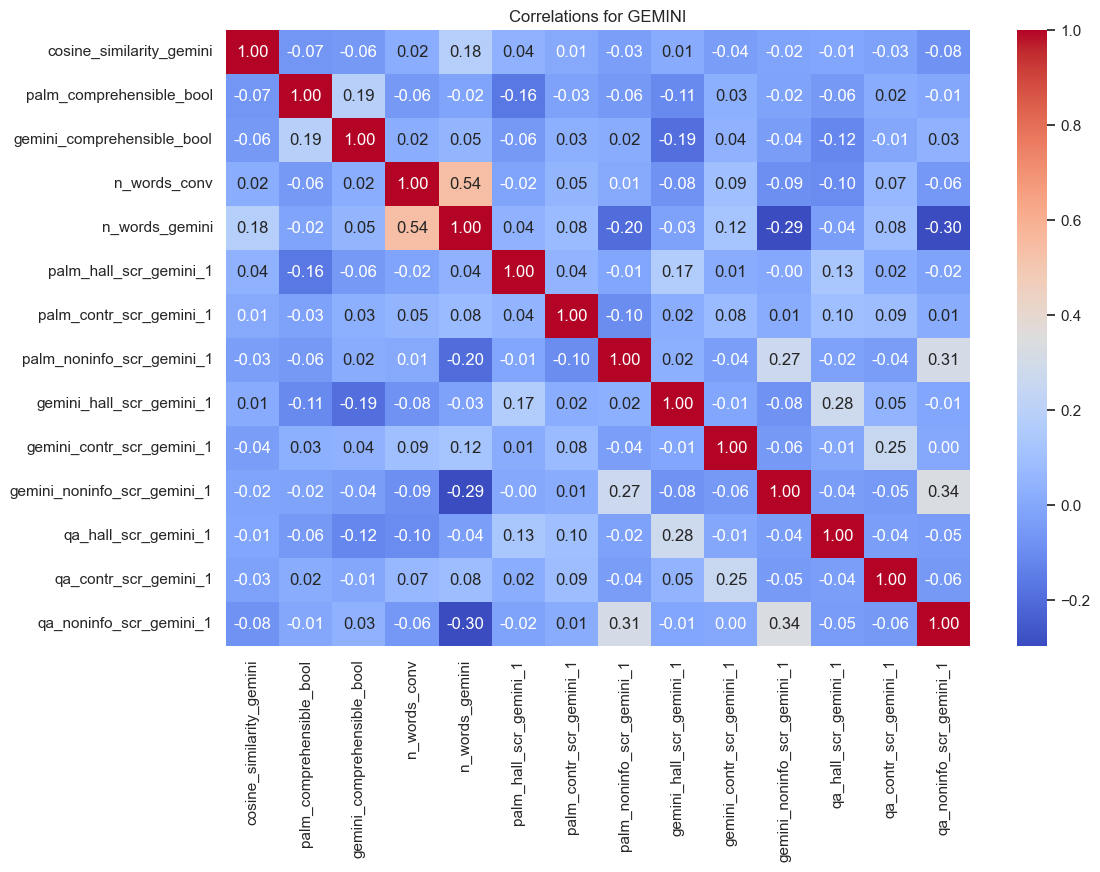

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    df[
        [
            f'cosine_similarity_{SUMM3}',
            f'palm_comprehensible_bool',
            f'gemini_comprehensible_bool',
            f'n_words_conv',
            f'n_words_{SUMM3}',
            f'palm_hall_scr_{SUMM3}_1',
            f'palm_contr_scr_{SUMM3}_1',
            f'palm_noninfo_scr_{SUMM3}_1',
            f'gemini_hall_scr_{SUMM3}_1',
            f'gemini_contr_scr_{SUMM3}_1',
            f'gemini_noninfo_scr_{SUMM3}_1',
            f'qa_hall_scr_{SUMM3}_1',
            f'qa_contr_scr_{SUMM3}_1',
            f'qa_noninfo_scr_{SUMM3}_1',
        ]
    ].corr(),
    annot = True,
    cmap = 'coolwarm',
    fmt='.2f'
)
plt.title(f'Correlations for {SUMM3.upper()}')
plt.show()

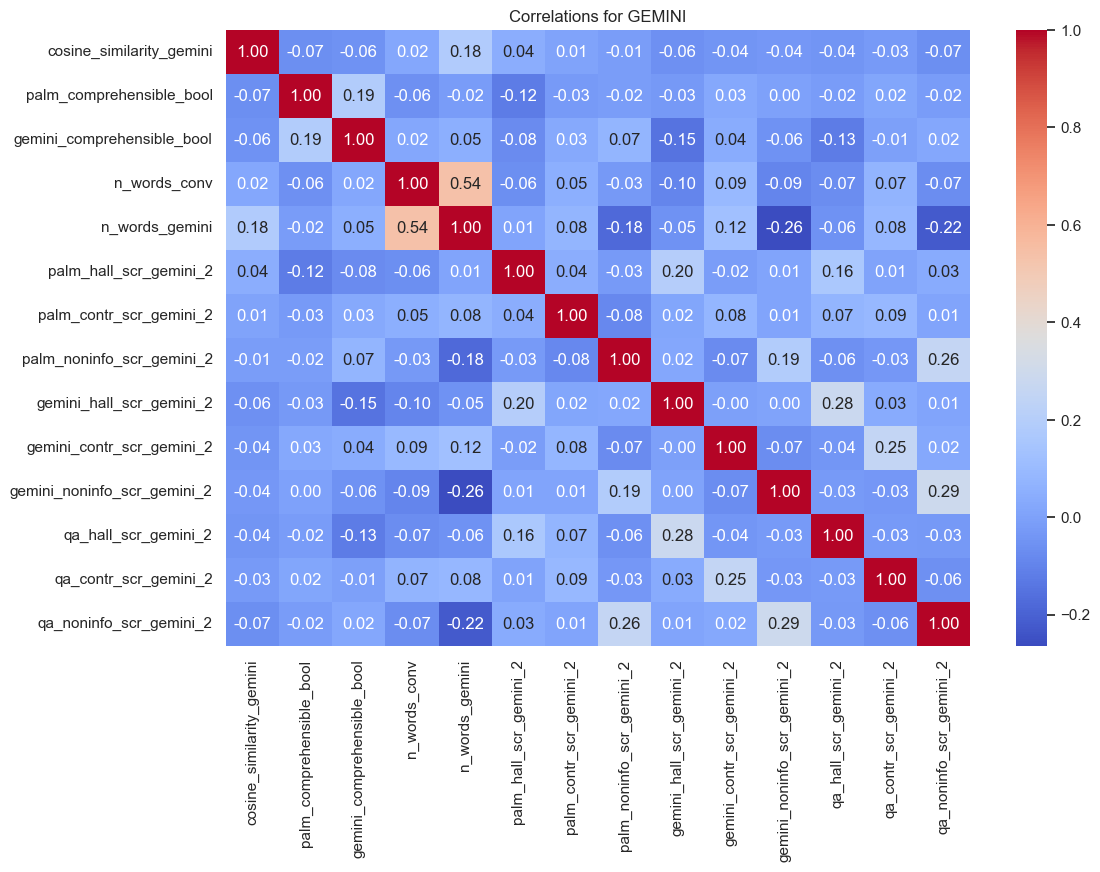

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    df[
        [
            f'cosine_similarity_{SUMM3}',
            f'palm_comprehensible_bool',
            f'gemini_comprehensible_bool',
            f'n_words_conv',
            f'n_words_{SUMM3}',
            f'palm_hall_scr_{SUMM3}_2',
            f'palm_contr_scr_{SUMM3}_2',
            f'palm_noninfo_scr_{SUMM3}_2',
            f'gemini_hall_scr_{SUMM3}_2',
            f'gemini_contr_scr_{SUMM3}_2',
            f'gemini_noninfo_scr_{SUMM3}_2',
            f'qa_hall_scr_{SUMM3}_2',
            f'qa_contr_scr_{SUMM3}_2',
            f'qa_noninfo_scr_{SUMM3}_2',
        ]
    ].corr(),
    annot = True,
    cmap = 'coolwarm',
    fmt='.2f'
)
plt.title(f'Correlations for {SUMM3.upper()}')
plt.show()

For the summaries generated by Gemini, the correlation between the lengths of the summaries and the lengths of the conversations is even stronger than the other models. Also, the longer the summary, the higher the cosine similarity with the conversation.

The obvious negative correlation between the lengths of the summaries and their noninformativeness score is present also for the summaries generated by Gemini. The negative relationship between the comprehensible score and the hallucination score holds too.

Overall, there is a higher correlation between the metrics for the summaries generated by Gemini, hinting a more consistent summarization process.